# Exploring Hypotheses on Synthetic Functions  

The purpose of this notebook is to find out more about the effect of the sampling bias and measures against it. 

In particular, we will explore the following hypotheses: 

* Why should we compute the PDP on uniformly distributed test data? 
* What is the effect of the sampling bias on the PDP? 
* How can we capture this effect an tell the user? 
* How can we reduce the sampling bias? 



In [518]:
# test function
library("smoof")
library("ParamHelpers")

# data handling
library("data.table")
library("BBmisc")

# visualization
library("plot3D")
library("ggplot2")
library("GGally")
library("gridExtra")
library("gginnards")
library("rpart.plot")
library("rattle")
library("RColorBrewer")
library("DiceKriging")

# mlrMBO
library("mlrMBO")
library("mlr")

# iml methods
library("iml")

# splitting
# withr::with_envvar(c(R_REMOTES_NO_ERRORS_FROM_WARNINGS="true"),remotes::install_github('giuseppec/customtrees'))
library("customtrees")

library("ggpubr")

theme_set(theme_pubr())

source("../R/mbo_helpers.R")
source("../R/pdp_helpers.R")
source("../R/tree_splitting.R")
source("../R/helper_evaluation.r")

setwd("../notebooks/")

In [342]:
cross.kernel = function(d1, d2 = NULL, sigma) {
  checkmate::assert_data_frame(d1, any.missing = FALSE)
  checkmate::assert_data_frame(d2, null.ok = TRUE, ncols = ncol(d1), any.missing = FALSE)
  checkmate::assert_number(sigma, lower = 0)
  mradial = kernlab::rbfdot(sigma = sigma)
  mm = kernlab::kernelMatrix(mradial, as.matrix(d1), as.matrix(d2))
  mean(mm)
}


get_median_dist = function(d){
  checkmate::assert_data_frame(d)
  dists = dist(d, diag = FALSE, upper = FALSE, method = "euclidean")
  median(dists)
}

mmd2 = function(d1, d2, sigma = NULL) {
  checkmate::assert_data_frame(d1, any.missing = FALSE)
  checkmate::assert_data_frame(d2, null.ok = TRUE, ncols = ncol(d1), any.missing = FALSE)
  checkmate::assert_number(sigma, lower = 0, null.ok = TRUE)
  d1 = data.frame(model.matrix(~ . -1, data = d1))
  d2 = data.frame(model.matrix(~ . -1, data = d2))
  if(is.null(sigma)) {
    sigma = get_median_dist(rbind(d1, d2))
    # Confusingly, the sigma in rbfdot is acutally the gamma param
    sigma = 1/(2 * sigma^2)
  }
  cross.kernel(d1, d1, sigma = sigma) - 2 * cross.kernel(d1, d2, sigma = sigma) + cross.kernel(d2, d2, sigma = sigma)
}

In [343]:
options(repr.plot.width=10, repr.plot.height=10)

In [344]:
runtimes = readRDS("../data/runs/synthetic/StyblinskiTang/runtimes.rds")

In [345]:
runtimes

$`2`
[1] 50

$`3`
[1] 100

$`5`
[1] 150

$`10`
[1] 250

## Scenario - Optimizing a Synthetic Test Function via mlrMBO

### Preparation: Objective Function

We optimize the 3D StyblinkskiTang function. 

In [261]:
# obj2 = makeSingleObjectiveFunction(name = "Rastrigin", fn = function(x) {
#         20 + sum(x^2 - 10 * cos(2 * pi * x))
#     }, 
#     par.set = makeParamSet(makeNumericVectorParam(id = "x", len = 2, lower = - 5, upper = 3))# 
# )

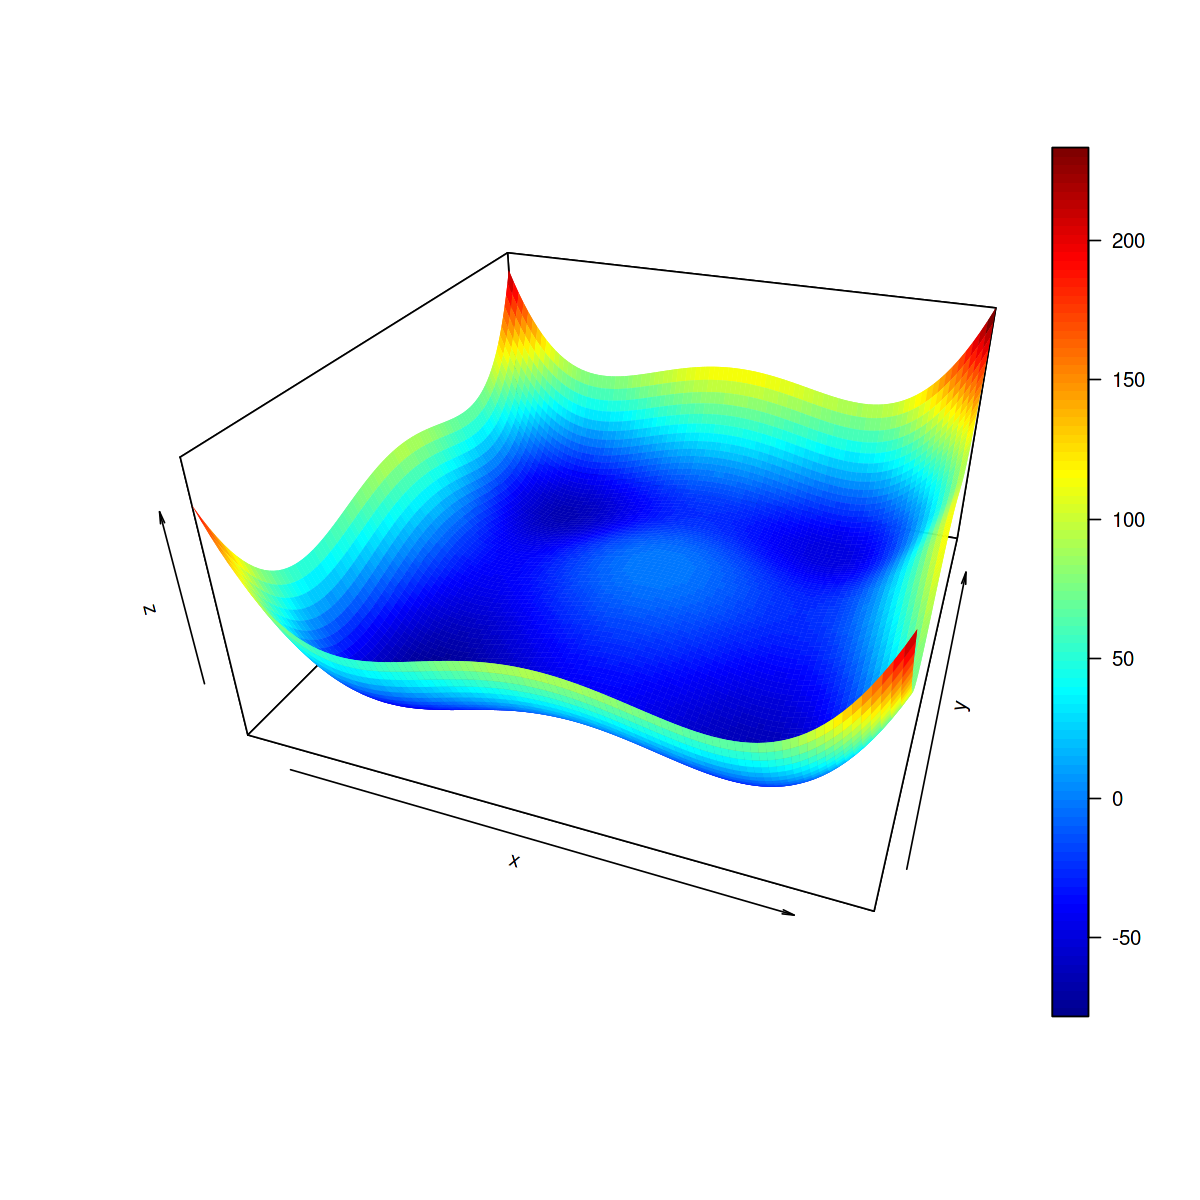

In [262]:
ps = getParamSet(obj1)

ps_ids = getParamIds(ps, repeated = TRUE, with.nr = TRUE)

x1 <- seq(from = ps$pars$x$lower[1], to = ps$pars$x$upper[1], length.out = 100)
x2 <- x1
y = outer(x1, x2, FUN = function(x1, x2) apply(cbind(x1, x2), 1, obj1))
          
persp3D(x1, x2, y, theta = 20, phi = 30, expand = 0.5, border = NA)

In [263]:
# ps = getParamSet(obj2)

# x11 <- seq(from = ps$pars$x$lower[1], to = ps$pars$x$upper[1], length.out = 100)
# x22 <- x11
# y2 = outer(x1, x2, FUN = function(x1, x2) apply(cbind(x1, x2), 1, obj2))
          
# persp3D(x11, x22, y2, theta = 20, phi = 30, expand = 0.5, border = NA)

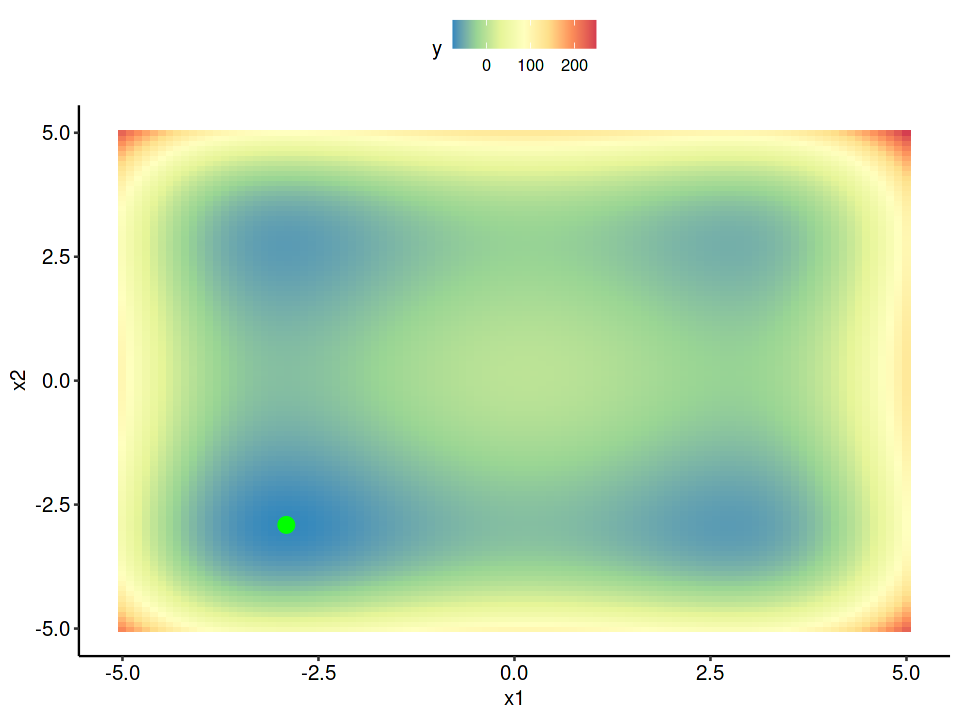

In [390]:
options(repr.plot.width=8, repr.plot.height=6)

gg <- expand.grid(x1 = x1, x2 = x2)
gg$y = apply(gg, 1, obj1)

# gg2 <- expand.grid(x1 = x11, x2 = x22)
# gg2$y = apply(gg2, 1, obj2)


p_obj_1 = ggplot() + geom_tile(data = gg, aes(x = x1, y = x2, fill = y))
p_obj_1 = p_obj_1 + scale_fill_distiller(palette = "Spectral")
p_obj_1 = p_obj_1 + geom_point(data = data.frame(x = -2.91, y = -2.91), aes(x = x, y = y), colour = "green", size = 4)

# p_obj_2 = ggplot() + geom_tile(data = gg2, aes(x = x1, y = x2, fill = y))
# p_obj_2 = p_obj_2 + scale_fill_distiller(palette = "Spectral")
# p_obj_2 = p_obj_2 + geom_point(data = data.frame(x = 0, y = 0), aes(x = x, y = y), colour = "green", size = 4)

p_obj_1

### Preparation: Creating MBO Runs

Next, we create `mlrMBO` runs as well as a model fitted on the randomLHS data. 

In [355]:
lambdas = c(0.1, 1, 2, 5, 100)

In [370]:
dimension = 2
id = "StyblinskiTang"

path = file.path("../data/runs/synthetic", id, paste0(dimension, "D"))

dir.create(path, recursive = TRUE)

obj1 = makeSingleObjectiveFunction(name = paste0(id, dimension, "D"), fn = function(x) {
        1 / 2 * sum(x^4 - 16 * x^2 + 5 * x)
    }, 
    par.set = makeParamSet(makeNumericVectorParam(id = "x", len = dimension, lower = - 5, upper = 5)), 
    global.opt.params = rep(-2.9035, dimension)
)

obj = obj1

Warning message in dir.create(path, recursive = TRUE):
“'../data/runs/synthetic/StyblinskiTang/2D' already exists”


In [371]:
getParamSet(obj)

           Type len Def  Constr Req Tunable Trafo
x numericvector   2   - -5 to 5   -    TRUE     -

In [373]:
for (lambda in lambdas) {
    createMBOrun(fun = obj, max.evals = 50, lambda = lambda, 
                 store_path = file.path(path, paste0("mlrmbo_run_lambda_", lambda, "matern32.rds")), 
                 seed = 1234, eval_performance = TRUE, kernel = "matern3_2")    
}


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 7.030581e-06 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  17.82472 15.58793 
  - variance bounds :  70.30581 9149.6 
  - best initial criterion value(s) :  -37.33105 


Wed Jan 27 13:44:25 2021
Domains:
 1.000000e-10   <=  X1   <=    1.782472e+01 
 1.000000e-10   <=  X2   <=    1.558793e+01 
 7.030581e+01   <=  X3   <=    9.149600e+03 

NOTE: The total number of operators greater than population size
NOTE: I'm increasing the population size to 10 (operators+1).

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	0
	(2) Uniform Mutation.................. 	1
	(3) Boundary Mutation................. 	1
	(4) Non-Uniform Mutation.............. 	1
	(5) Polytope Crossover................ 	1
	(6) Simple Cro

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -5.046097e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	3.897990e+00	G[ 1] :	-3.080305e-07
 X[ 2] :	3.421093e+00	G[ 2] :	-9.016822e-07
 X[ 3] :	1.424400e+03	G[ 3] :	1.297561e-09

Solution Found Generation 4
Number of Generations Run 5

Wed Jan 27 13:44:29 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 1.062615e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  17.82472 15.58793 
  - variance bounds :  106.2615 18169.52 
  - best initial criterion value(s) :  -74.31942 


Wed Jan 27 13:44:30 2021
Domains:
 1.000000e-10   <=  X1   <=    1.782472e+01 
 1.000000e-10   <=  X2   <=    1.558793e+01 
 1.062615e+02   <=  X3   <=    1.816952e+04 

NOTE: The total number of oper

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -3.183714e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	9.000861e+00	G[ 1] :	5.298071e-06
 X[ 2] :	9.530268e+00	G[ 2] :	-2.336361e-06
 X[ 3] :	1.302295e+04	G[ 3] :	-6.559949e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:44:32 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 9.252203e-06 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  17.82472 15.58793 
  - variance bounds :  92.52202 17694.2 
  - best initial criterion value(s) :  -33.76736 


Wed Jan 27 13:44:33 2021
Domains:
 1.000000e-10   <=  X1   <=    1.782472e+01 
 1.000000e-10   <=  X2   <=    1.558793e+01 
 9.252202e+01   <=  X3   <=    1.769420e+04 

NOTE: The total number of opera

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: 2.460253e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	8.896856e+00	G[ 1] :	2.932494e-05
 X[ 2] :	9.513078e+00	G[ 2] :	3.887518e-05
 X[ 3] :	1.145231e+04	G[ 3] :	-6.467967e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:44:39 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 7.125033e-06 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  17.82472 15.58793 
  - variance bounds :  71.25033 14268.01 
  - best initial criterion value(s) :  19.78641 


Wed Jan 27 13:44:40 2021
Domains:
 1.000000e-10   <=  X1   <=    1.782472e+01 
 1.000000e-10   <=  X2   <=    1.558793e+01 
 7.125033e+01   <=  X3   <=    1.426801e+04 

NOTE: The total number of operato

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: 2.994678e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	6.226106e+00	G[ 1] :	2.133062e-04
 X[ 2] :	6.416415e+00	G[ 2] :	-1.406719e-04
 X[ 3] :	4.012317e+03	G[ 3] :	-1.059029e-04

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:44:40 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 6.985889e-06 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  17.82472 15.58793 
  - variance bounds :  69.85888 13970.71 
  - best initial criterion value(s) :  6.070927 


Wed Jan 27 13:44:41 2021
Domains:
 1.000000e-10   <=  X1   <=    1.782472e+01 
 1.000000e-10   <=  X2   <=    1.558793e+01 
 6.985888e+01   <=  X3   <=    1.397071e+04 

NOTE: The total number of operat

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: 4.481279e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	5.685655e+00	G[ 1] :	-1.379253e-04
 X[ 2] :	5.847014e+00	G[ 2] :	2.120867e-04
 X[ 3] :	3.063784e+03	G[ 3] :	-7.265735e-05

Solution Found Generation 4
Number of Generations Run 5

Wed Jan 27 13:44:42 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 6.596928e-06 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  17.82472 15.58793 
  - variance bounds :  65.96928 13207.94 
  - best initial criterion value(s) :  46.45824 


Wed Jan 27 13:44:43 2021
Domains:
 1.000000e-10   <=  X1   <=    1.782472e+01 
 1.000000e-10   <=  X2   <=    1.558793e+01 
 6.596928e+01   <=  X3   <=    1.320794e+04 

NOTE: The total number of operat

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: 5.430569e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	8.576998e+00	G[ 1] :	-3.633885e-07
 X[ 2] :	9.309685e+00	G[ 2] :	6.115299e-06
 X[ 3] :	1.014610e+04	G[ 3] :	-6.686878e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:44:44 2021
Total run time : 0 hours 0 minutes and 1 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 6.359306e-06 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  17.82472 15.58793 
  - variance bounds :  63.59306 12718.31 
  - best initial criterion value(s) :  57.16111 


Wed Jan 27 13:44:44 2021
Domains:
 1.000000e-10   <=  X1   <=    1.782472e+01 
 1.000000e-10   <=  X2   <=    1.558793e+01 
 6.359306e+01   <=  X3   <=    1.271831e+04 

NOTE: The total number of operat

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: 7.004684e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	6.093031e+00	G[ 1] :	1.467255e-04
 X[ 2] :	6.395391e+00	G[ 2] :	1.074464e-04
 X[ 3] :	3.704511e+03	G[ 3] :	-8.398445e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:44:46 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 6.031693e-06 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  17.82472 15.58793 
  - variance bounds :  60.31693 12063.3 
  - best initial criterion value(s) :  67.12661 


Wed Jan 27 13:44:46 2021
Domains:
 1.000000e-10   <=  X1   <=    1.782472e+01 
 1.000000e-10   <=  X2   <=    1.558793e+01 
 6.031693e+01   <=  X3   <=    1.206330e+04 

NOTE: The total number of operator

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -4.513169e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	7.320891e-02	G[ 1] :	-7.555945e-06
 X[ 2] :	1.660904e+01	G[ 2] :	9.077744e-03
 X[ 3] :	5.551226e+02	G[ 3] :	8.695437e-06

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:44:57 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 6.173978e-06 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  17.82472 16.60904 
  - variance bounds :  61.73978 6601.045 
  - best initial criterion value(s) :  -81.56892 


Wed Jan 27 13:44:57 2021
Domains:
 1.000000e-10   <=  X1   <=    1.782472e+01 
 1.000000e-10   <=  X2   <=    1.660904e+01 
 6.173978e+01   <=  X3   <=    6.601045e+03 

NOTE: The total number of opera

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -7.963038e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	2.346558e-01	G[ 1] :	-1.702281e-04
 X[ 2] :	1.660904e+01	G[ 2] :	7.779160e-02
 X[ 3] :	8.608860e+03	G[ 3] :	-5.827694e-04

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:44:59 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 2.349912e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.47951 17.60118 
  - variance bounds :  234.9912 28646.53 
  - best initial criterion value(s) :  -84.40934 


Wed Jan 27 13:45:00 2021
Domains:
 1.000000e-10   <=  X1   <=    1.947951e+01 
 1.000000e-10   <=  X2   <=    1.760118e+01 
 2.349912e+02   <=  X3   <=    2.864653e+04 

NOTE: The total number of oper

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -8.994967e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	5.431459e+00	G[ 1] :	-2.457560e-06
 X[ 2] :	4.971334e+00	G[ 2] :	-3.046357e-05
 X[ 3] :	1.930573e+04	G[ 3] :	-3.889298e-05

Solution Found Generation 4
Number of Generations Run 5

Wed Jan 27 13:45:00 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 2.175304e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.47951 17.60118 
  - variance bounds :  217.5304 26216.1 
  - best initial criterion value(s) :  -97.01894 


Wed Jan 27 13:45:01 2021
Domains:
 1.000000e-10   <=  X1   <=    1.947951e+01 
 1.000000e-10   <=  X2   <=    1.760118e+01 
 2.175304e+02   <=  X3   <=    2.621610e+04 

NOTE: The total number of oper

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.121890e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	4.021939e+00	G[ 1] :	-1.063878e-04
 X[ 2] :	3.918899e+00	G[ 2] :	-2.188542e-04
 X[ 3] :	7.656860e+03	G[ 3] :	3.273757e-05

Solution Found Generation 4
Number of Generations Run 5

Wed Jan 27 13:45:03 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 2.229748e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.47951 17.60118 
  - variance bounds :  222.9748 27898.05 
  - best initial criterion value(s) :  -120.7311 


Wed Jan 27 13:45:03 2021
Domains:
 1.000000e-10   <=  X1   <=    1.947951e+01 
 1.000000e-10   <=  X2   <=    1.760118e+01 
 2.229748e+02   <=  X3   <=    2.789805e+04 

NOTE: The total number of oper

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.150091e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	4.839394e+00	G[ 1] :	2.353255e-05
 X[ 2] :	4.949423e+00	G[ 2] :	2.969477e-05
 X[ 3] :	1.069781e+04	G[ 3] :	5.816083e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:45:04 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 2.245798e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.47951 17.60118 
  - variance bounds :  224.5798 27987.78 
  - best initial criterion value(s) :  -158.8371 


Wed Jan 27 13:45:04 2021
Domains:
 1.000000e-10   <=  X1   <=    1.947951e+01 
 1.000000e-10   <=  X2   <=    1.760118e+01 
 2.245798e+02   <=  X3   <=    2.798778e+04 

NOTE: The total number of operat

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.170013e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	3.866071e+00	G[ 1] :	-3.786839e-04
 X[ 2] :	3.751666e+00	G[ 2] :	-2.350626e-04
 X[ 3] :	5.859425e+03	G[ 3] :	2.010882e-04

Solution Found Generation 4
Number of Generations Run 5

Wed Jan 27 13:45:04 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 2.244411e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.47951 17.60118 
  - variance bounds :  224.4411 28489.45 
  - best initial criterion value(s) :  -138.039 


Wed Jan 27 13:45:05 2021
Domains:
 1.000000e-10   <=  X1   <=    1.947951e+01 
 1.000000e-10   <=  X2   <=    1.760118e+01 
 2.244411e+02   <=  X3   <=    2.848945e+04 

NOTE: The total number of opera

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.159364e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	6.443132e+00	G[ 1] :	6.941906e-06
 X[ 2] :	6.621844e+00	G[ 2] :	-5.973614e-06
 X[ 3] :	1.847464e+04	G[ 3] :	4.581433e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:45:05 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 2.225381e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.47951 17.60118 
  - variance bounds :  222.5381 28877.86 
  - best initial criterion value(s) :  -129.5937 


Wed Jan 27 13:45:06 2021
Domains:
 1.000000e-10   <=  X1   <=    1.947951e+01 
 1.000000e-10   <=  X2   <=    1.760118e+01 
 2.225381e+02   <=  X3   <=    2.887786e+04 

NOTE: The total number of opera

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.110673e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	7.725605e+00	G[ 1] :	1.104326e-06
 X[ 2] :	8.093021e+00	G[ 2] :	-1.088234e-06
 X[ 3] :	2.591344e+04	G[ 3] :	4.031676e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:45:08 2021
Total run time : 0 hours 0 minutes and 1 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 2.149709e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.47951 17.60118 
  - variance bounds :  214.9709 28014.11 
  - best initial criterion value(s) :  -204.5815 


Wed Jan 27 13:45:08 2021
Domains:
 1.000000e-10   <=  X1   <=    1.947951e+01 
 1.000000e-10   <=  X2   <=    1.760118e+01 
 2.149709e+02   <=  X3   <=    2.801411e+04 

NOTE: The total number of opera

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.028552e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	7.936375e+00	G[ 1] :	-1.067908e-05
 X[ 2] :	8.299747e+00	G[ 2] :	9.803910e-06
 X[ 3] :	2.531817e+04	G[ 3] :	4.944350e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:45:09 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 2.077581e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.47951 17.60118 
  - variance bounds :  207.7581 27760.49 
  - best initial criterion value(s) :  -166.5536 


Wed Jan 27 13:45:10 2021
Domains:
 1.000000e-10   <=  X1   <=    1.947951e+01 
 1.000000e-10   <=  X2   <=    1.760118e+01 
 2.077581e+02   <=  X3   <=    2.776049e+04 

NOTE: The total number of opera

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.006858e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	7.064372e+00	G[ 1] :	1.324952e-05
 X[ 2] :	7.136154e+00	G[ 2] :	-8.797248e-06
 X[ 3] :	1.730704e+04	G[ 3] :	9.104999e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:45:10 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 2.052292e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.47951 17.60118 
  - variance bounds :  205.2292 27763.93 
  - best initial criterion value(s) :  -106.15 


Wed Jan 27 13:45:11 2021
Domains:
 1.000000e-10   <=  X1   <=    1.947951e+01 
 1.000000e-10   <=  X2   <=    1.760118e+01 
 2.052292e+02   <=  X3   <=    2.776393e+04 

NOTE: The total number of operato

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -9.281846e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	8.321202e+00	G[ 1] :	2.242044e-04
 X[ 2] :	8.597432e+00	G[ 2] :	-2.155357e-04
 X[ 3] :	2.635977e+04	G[ 3] :	5.168380e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:45:11 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 2.000981e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.47951 17.60118 
  - variance bounds :  200.0981 27692.31 
  - best initial criterion value(s) :  -105.944 


Wed Jan 27 13:45:12 2021
Domains:
 1.000000e-10   <=  X1   <=    1.947951e+01 
 1.000000e-10   <=  X2   <=    1.760118e+01 
 2.000981e+02   <=  X3   <=    2.769231e+04 

NOTE: The total number of operat

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -8.087872e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	8.942687e+00	G[ 1] :	-4.531925e-05
 X[ 2] :	9.311436e+00	G[ 2] :	5.386199e-05
 X[ 3] :	3.109782e+04	G[ 3] :	4.272852e-05

Solution Found Generation 4
Number of Generations Run 5

Wed Jan 27 13:45:13 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 1.924017e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.47951 17.60118 
  - variance bounds :  192.4017 31481.68 
  - best initial criterion value(s) :  -114.2721 


Wed Jan 27 13:45:14 2021
Domains:
 1.000000e-10   <=  X1   <=    1.947951e+01 
 1.000000e-10   <=  X2   <=    1.760118e+01 
 1.924017e+02   <=  X3   <=    3.148168e+04 

NOTE: The total number of opera

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -7.670244e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	9.001055e+00	G[ 1] :	2.986257e-05
 X[ 2] :	9.400980e+00	G[ 2] :	1.816384e-06
 X[ 3] :	3.148168e+04	G[ 3] :	4.258969e-05

Solution Found Generation 4
Number of Generations Run 5

Wed Jan 27 13:45:14 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 1.898705e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.47951 17.60118 
  - variance bounds :  189.8705 32106.49 
  - best initial criterion value(s) :  -92.38252 


Wed Jan 27 13:45:14 2021
Domains:
 1.000000e-10   <=  X1   <=    1.947951e+01 
 1.000000e-10   <=  X2   <=    1.760118e+01 
 1.898705e+02   <=  X3   <=    3.210649e+04 

NOTE: The total number of operat

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -6.421476e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	8.735404e+00	G[ 1] :	-4.683312e-05
 X[ 2] :	9.112924e+00	G[ 2] :	5.170686e-05
 X[ 3] :	2.848461e+04	G[ 3] :	5.091135e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:45:16 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 1.824523e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.47951 17.60118 
  - variance bounds :  182.4523 31876 
  - best initial criterion value(s) :  -84.29688 


Wed Jan 27 13:45:16 2021
Domains:
 1.000000e-10   <=  X1   <=    1.947951e+01 
 1.000000e-10   <=  X2   <=    1.760118e+01 
 1.824523e+02   <=  X3   <=    3.187600e+04 

NOTE: The total number of operator

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -4.251810e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	8.730041e+00	G[ 1] :	-1.485187e-04
 X[ 2] :	9.142772e+00	G[ 2] :	-4.173299e-04
 X[ 3] :	2.787255e+04	G[ 3] :	5.468743e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:45:19 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 7.030581e-06 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  17.82472 15.58793 
  - variance bounds :  70.30581 9149.6 
  - best initial criterion value(s) :  -37.33105 


Wed Jan 27 13:45:28 2021
Domains:
 1.000000e-10   <=  X1   <=    1.782472e+01 
 1.000000e-10   <=  X2   <=    1.558793e+01 
 7.030581e+01   <=  X3   <=    9.149600e+03 

NOTE: The total number of operat

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.072231e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	4.357078e+00	G[ 1] :	-1.393824e-05
 X[ 2] :	3.957483e+00	G[ 2] :	-1.284390e-05
 X[ 3] :	9.180648e+03	G[ 3] :	-3.923636e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:45:34 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 3.106642e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.94561 19.99952 
  - variance bounds :  310.6642 39245.63 
  - best initial criterion value(s) :  -282.492 


Wed Jan 27 13:45:34 2021
Domains:
 1.000000e-10   <=  X1   <=    1.994561e+01 
 1.000000e-10   <=  X2   <=    1.999952e+01 
 3.106642e+02   <=  X3   <=    3.924563e+04 

NOTE: The total number of oper

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.335881e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	5.900083e+00	G[ 1] :	5.662246e-06
 X[ 2] :	5.821073e+00	G[ 2] :	2.987848e-06
 X[ 3] :	1.368516e+04	G[ 3] :	9.468186e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:45:39 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 3.121054e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.94561 19.99952 
  - variance bounds :  312.1054 41698.1 
  - best initial criterion value(s) :  -156.8619 


Wed Jan 27 13:45:40 2021
Domains:
 1.000000e-10   <=  X1   <=    1.994561e+01 
 1.000000e-10   <=  X2   <=    1.999952e+01 
 3.121054e+02   <=  X3   <=    4.169810e+04 

NOTE: The total number of operato

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.333713e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	6.346062e+00	G[ 1] :	-1.371567e-04
 X[ 2] :	6.381729e+00	G[ 2] :	-2.427776e-05
 X[ 3] :	1.630543e+04	G[ 3] :	7.450067e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:45:40 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 3.09753e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.94561 19.99952 
  - variance bounds :  309.753 41667.27 
  - best initial criterion value(s) :  -165.0475 


Wed Jan 27 13:45:40 2021
Domains:
 1.000000e-10   <=  X1   <=    1.994561e+01 
 1.000000e-10   <=  X2   <=    1.999952e+01 
 3.097530e+02   <=  X3   <=    4.166727e+04 

NOTE: The total number of operat

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.305342e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	9.201923e+00	G[ 1] :	6.987637e-07
 X[ 2] :	9.409701e+00	G[ 2] :	6.131032e-07
 X[ 3] :	4.055850e+04	G[ 3] :	1.753850e-05

Solution Found Generation 4
Number of Generations Run 5

Wed Jan 27 13:45:42 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 2.981477e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.94561 19.99952 
  - variance bounds :  298.1477 40357.69 
  - best initial criterion value(s) :  -198.4938 


Wed Jan 27 13:45:43 2021
Domains:
 1.000000e-10   <=  X1   <=    1.994561e+01 
 1.000000e-10   <=  X2   <=    1.999952e+01 
 2.981477e+02   <=  X3   <=    4.035769e+04 

NOTE: The total number of operat

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.290512e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	8.533204e+00	G[ 1] :	-4.874805e-06
 X[ 2] :	8.677045e+00	G[ 2] :	8.246482e-07
 X[ 3] :	3.158473e+04	G[ 3] :	2.989013e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:45:43 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 2.949221e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.94561 19.99952 
  - variance bounds :  294.9221 40087.91 
  - best initial criterion value(s) :  -246.9048 


Wed Jan 27 13:45:43 2021
Domains:
 1.000000e-10   <=  X1   <=    1.994561e+01 
 1.000000e-10   <=  X2   <=    1.999952e+01 
 2.949221e+02   <=  X3   <=    4.008791e+04 

NOTE: The total number of opera

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.165042e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	8.186562e+00	G[ 1] :	4.685549e-06
 X[ 2] :	8.169272e+00	G[ 2] :	1.539612e-06
 X[ 3] :	2.356646e+04	G[ 3] :	6.302612e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:45:46 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 2.747407e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.94561 19.99952 
  - variance bounds :  274.7407 38095.35 
  - best initial criterion value(s) :  -177.187 


Wed Jan 27 13:45:47 2021
Domains:
 1.000000e-10   <=  X1   <=    1.994561e+01 
 1.000000e-10   <=  X2   <=    1.999952e+01 
 2.747407e+02   <=  X3   <=    3.809535e+04 

NOTE: The total number of operato

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.135936e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	7.855264e+00	G[ 1] :	3.138280e-06
 X[ 2] :	7.883237e+00	G[ 2] :	-3.891772e-06
 X[ 3] :	2.073292e+04	G[ 3] :	8.125164e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:45:47 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 2.713863e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.94561 19.99952 
  - variance bounds :  271.3863 38182.09 
  - best initial criterion value(s) :  -173.7044 


Wed Jan 27 13:45:47 2021
Domains:
 1.000000e-10   <=  X1   <=    1.994561e+01 
 1.000000e-10   <=  X2   <=    1.999952e+01 
 2.713863e+02   <=  X3   <=    3.818209e+04 

NOTE: The total number of opera

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.095309e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	9.599273e+00	G[ 1] :	4.943316e-05
 X[ 2] :	9.653619e+00	G[ 2] :	6.637873e-05
 X[ 3] :	3.601892e+04	G[ 3] :	2.954936e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:45:47 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 2.68059e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.94561 19.99952 
  - variance bounds :  268.059 38061.14 
  - best initial criterion value(s) :  -163.6926 


Wed Jan 27 13:45:48 2021
Domains:
 1.000000e-10   <=  X1   <=    1.994561e+01 
 1.000000e-10   <=  X2   <=    1.999952e+01 
 2.680590e+02   <=  X3   <=    3.806114e+04 

NOTE: The total number of operator

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -9.447696e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	9.897267e+00	G[ 1] :	9.847601e-06
 X[ 2] :	9.859779e+00	G[ 2] :	6.240025e-06
 X[ 3] :	3.707593e+04	G[ 3] :	2.913601e-05

Solution Found Generation 4
Number of Generations Run 5

Wed Jan 27 13:45:50 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 2.551149e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.94561 19.99952 
  - variance bounds :  255.1149 37200.15 
  - best initial criterion value(s) :  -106.3731 


Wed Jan 27 13:45:51 2021
Domains:
 1.000000e-10   <=  X1   <=    1.994561e+01 
 1.000000e-10   <=  X2   <=    1.999952e+01 
 2.551149e+02   <=  X3   <=    3.720015e+04 

NOTE: The total number of operat

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -9.053901e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	9.547039e+00	G[ 1] :	3.946834e-05
 X[ 2] :	9.495475e+00	G[ 2] :	7.654731e-05
 X[ 3] :	3.314507e+04	G[ 3] :	3.633032e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:45:51 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 7.030581e-06 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  17.82472 15.58793 
  - variance bounds :  70.30581 9149.6 
  - best initial criterion value(s) :  -37.33105 


Wed Jan 27 13:45:59 2021
Domains:
 1.000000e-10   <=  X1   <=    1.782472e+01 
 1.000000e-10   <=  X2   <=    1.558793e+01 
 7.030581e+01   <=  X3   <=    9.149600e+03 

NOTE: The total number of operator

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -6.352394e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	1.606198e+00	G[ 1] :	8.561609e-05
 X[ 2] :	7.142726e+00	G[ 2] :	-4.785005e-05
 X[ 3] :	8.850524e+03	G[ 3] :	-3.440480e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:46:00 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 8.099856e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.5331 19.99747 
  - variance bounds :  809.9856 92664.25 
  - best initial criterion value(s) :  -70.99265 


Wed Jan 27 13:46:01 2021
Domains:
 1.000000e-10   <=  X1   <=    1.953310e+01 
 1.000000e-10   <=  X2   <=    1.999747e+01 
 8.099856e+02   <=  X3   <=    9.266425e+04 

NOTE: The total number of opera

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -8.741247e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	1.377695e+00	G[ 1] :	-9.777786e-07
 X[ 2] :	5.885716e+00	G[ 2] :	2.763709e-06
 X[ 3] :	1.067900e+04	G[ 3] :	-7.119194e-05

Solution Found Generation 4
Number of Generations Run 5

Wed Jan 27 13:46:02 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 8.786952e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.99964 19.99967 
  - variance bounds :  878.6952 98469.18 
  - best initial criterion value(s) :  -96.0703 


Wed Jan 27 13:46:03 2021
Domains:
 1.000000e-10   <=  X1   <=    1.999964e+01 
 1.000000e-10   <=  X2   <=    1.999967e+01 
 8.786952e+02   <=  X3   <=    9.846918e+04 

NOTE: The total number of opera

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -9.307677e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	1.724757e-01	G[ 1] :	6.024383e-06
 X[ 2] :	5.721921e+00	G[ 2] :	3.309035e-06
 X[ 3] :	7.969164e+03	G[ 3] :	-3.776881e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:46:03 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 8.608078e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.99964 19.99967 
  - variance bounds :  860.8078 96539.53 
  - best initial criterion value(s) :  -98.95317 


Wed Jan 27 13:46:03 2021
Domains:
 1.000000e-10   <=  X1   <=    1.999964e+01 
 1.000000e-10   <=  X2   <=    1.999967e+01 
 8.608078e+02   <=  X3   <=    9.653953e+04 

NOTE: The total number of opera

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.204008e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	7.082203e+00	G[ 1] :	-1.074865e-04
 X[ 2] :	5.896919e+00	G[ 2] :	-1.065330e-04
 X[ 3] :	4.038810e+04	G[ 3] :	1.158778e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:46:05 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 8.091248e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.99964 19.99967 
  - variance bounds :  809.1248 96723.37 
  - best initial criterion value(s) :  -150.3052 


Wed Jan 27 13:46:06 2021
Domains:
 1.000000e-10   <=  X1   <=    1.999964e+01 
 1.000000e-10   <=  X2   <=    1.999967e+01 
 8.091248e+02   <=  X3   <=    9.672337e+04 

NOTE: The total number of oper

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.289201e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	9.514537e+00	G[ 1] :	2.912775e-05
 X[ 2] :	8.390355e+00	G[ 2] :	-6.459464e-06
 X[ 3] :	7.426956e+04	G[ 3] :	1.689738e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:46:06 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 7.926482e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.99964 19.99967 
  - variance bounds :  792.6482 94467.29 
  - best initial criterion value(s) :  -138.7184 


Wed Jan 27 13:46:07 2021
Domains:
 1.000000e-10   <=  X1   <=    1.999964e+01 
 1.000000e-10   <=  X2   <=    1.999967e+01 
 7.926482e+02   <=  X3   <=    9.446729e+04 

NOTE: The total number of opera

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.330965e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	1.040186e+01	G[ 1] :	-6.329011e-06
 X[ 2] :	8.639815e+00	G[ 2] :	4.068574e-06
 X[ 3] :	8.576449e+04	G[ 3] :	1.602040e-05

Solution Found Generation 4
Number of Generations Run 5

Wed Jan 27 13:46:07 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 7.932243e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.99964 19.99967 
  - variance bounds :  793.2243 95683.22 
  - best initial criterion value(s) :  -189.5152 


Wed Jan 27 13:46:07 2021
Domains:
 1.000000e-10   <=  X1   <=    1.999964e+01 
 1.000000e-10   <=  X2   <=    1.999967e+01 
 7.932243e+02   <=  X3   <=    9.568322e+04 

NOTE: The total number of opera

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.403073e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	1.088337e+01	G[ 1] :	1.198586e-04
 X[ 2] :	9.256863e+00	G[ 2] :	9.183385e-05
 X[ 3] :	8.896551e+04	G[ 3] :	2.079217e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:46:08 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 8.058707e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.99964 19.99967 
  - variance bounds :  805.8707 98098.96 
  - best initial criterion value(s) :  -151.9082 


Wed Jan 27 13:46:08 2021
Domains:
 1.000000e-10   <=  X1   <=    1.999964e+01 
 1.000000e-10   <=  X2   <=    1.999967e+01 
 8.058707e+02   <=  X3   <=    9.809896e+04 

NOTE: The total number of operat

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.474711e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	1.083190e+01	G[ 1] :	-2.056065e-05
 X[ 2] :	9.095054e+00	G[ 2] :	-7.941975e-06
 X[ 3] :	8.153829e+04	G[ 3] :	2.608389e-05

Solution Found Generation 4
Number of Generations Run 5

Wed Jan 27 13:46:09 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 7.800293e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.99964 19.99967 
  - variance bounds :  780.0292 96700.58 
  - best initial criterion value(s) :  -161.4341 


Wed Jan 27 13:46:09 2021
Domains:
 1.000000e-10   <=  X1   <=    1.999964e+01 
 1.000000e-10   <=  X2   <=    1.999967e+01 
 7.800292e+02   <=  X3   <=    9.670058e+04 

NOTE: The total number of oper

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.579157e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	1.076665e+01	G[ 1] :	8.260497e-05
 X[ 2] :	9.598749e+00	G[ 2] :	-1.593108e-05
 X[ 3] :	7.746454e+04	G[ 3] :	3.507836e-05

Solution Found Generation 4
Number of Generations Run 5

Wed Jan 27 13:46:11 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 7.46495e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.99964 19.99967 
  - variance bounds :  746.495 95543.01 
  - best initial criterion value(s) :  -188.5838 


Wed Jan 27 13:46:11 2021
Domains:
 1.000000e-10   <=  X1   <=    1.999964e+01 
 1.000000e-10   <=  X2   <=    1.999967e+01 
 7.464950e+02   <=  X3   <=    9.554301e+04 

NOTE: The total number of operato

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.613048e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	1.071479e+01	G[ 1] :	-3.611048e-06
 X[ 2] :	9.556111e+00	G[ 2] :	-1.266599e-05
 X[ 3] :	7.349283e+04	G[ 3] :	4.099053e-05

Solution Found Generation 4
Number of Generations Run 5

Wed Jan 27 13:46:11 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 7.371174e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.99964 19.99967 
  - variance bounds :  737.1174 95746.09 
  - best initial criterion value(s) :  -266.1652 


Wed Jan 27 13:46:12 2021
Domains:
 1.000000e-10   <=  X1   <=    1.999964e+01 
 1.000000e-10   <=  X2   <=    1.999967e+01 
 7.371174e+02   <=  X3   <=    9.574609e+04 

NOTE: The total number of oper

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.693477e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	1.177246e+01	G[ 1] :	-3.063463e-07
 X[ 2] :	1.072312e+01	G[ 2] :	5.552704e-06
 X[ 3] :	8.761969e+04	G[ 3] :	3.961862e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:46:13 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 7.202295e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.99964 19.99967 
  - variance bounds :  720.2295 91939.3 
  - best initial criterion value(s) :  -187.7197 


Wed Jan 27 13:46:14 2021
Domains:
 1.000000e-10   <=  X1   <=    1.999964e+01 
 1.000000e-10   <=  X2   <=    1.999967e+01 
 7.202295e+02   <=  X3   <=    9.193930e+04 

NOTE: The total number of operat

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.786821e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	1.121004e+01	G[ 1] :	-6.279766e-06
 X[ 2] :	1.038594e+01	G[ 2] :	1.459668e-05
 X[ 3] :	7.016604e+04	G[ 3] :	6.231455e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:46:15 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 6.930444e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.99964 19.99967 
  - variance bounds :  693.0444 90307.61 
  - best initial criterion value(s) :  -231.2052 


Wed Jan 27 13:46:16 2021
Domains:
 1.000000e-10   <=  X1   <=    1.999964e+01 
 1.000000e-10   <=  X2   <=    1.999967e+01 
 6.930444e+02   <=  X3   <=    9.030761e+04 

NOTE: The total number of opera

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.809469e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	1.171519e+01	G[ 1] :	-6.394271e-06
 X[ 2] :	1.061037e+01	G[ 2] :	1.142304e-05
 X[ 3] :	7.444927e+04	G[ 3] :	5.997015e-05

Solution Found Generation 4
Number of Generations Run 5

Wed Jan 27 13:46:16 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 6.890625e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.99964 19.99967 
  - variance bounds :  689.0625 89950.75 
  - best initial criterion value(s) :  -196.1297 


Wed Jan 27 13:46:17 2021
Domains:
 1.000000e-10   <=  X1   <=    1.999964e+01 
 1.000000e-10   <=  X2   <=    1.999967e+01 
 6.890625e+02   <=  X3   <=    8.995075e+04 

NOTE: The total number of opera

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.843594e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	1.100117e+01	G[ 1] :	2.672376e-06
 X[ 2] :	1.000638e+01	G[ 2] :	-4.986520e-05
 X[ 3] :	5.901787e+04	G[ 3] :	8.526403e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:46:18 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 6.657935e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.99964 19.99967 
  - variance bounds :  665.7935 85938.72 
  - best initial criterion value(s) :  -208.9376 


Wed Jan 27 13:46:18 2021
Domains:
 1.000000e-10   <=  X1   <=    1.999964e+01 
 1.000000e-10   <=  X2   <=    1.999967e+01 
 6.657935e+02   <=  X3   <=    8.593872e+04 

NOTE: The total number of opera

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.869995e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	1.146985e+01	G[ 1] :	4.039407e-06
 X[ 2] :	1.060963e+01	G[ 2] :	4.200757e-07
 X[ 3] :	6.626756e+04	G[ 3] :	7.816053e-05

Solution Found Generation 4
Number of Generations Run 5

Wed Jan 27 13:46:19 2021
Total run time : 0 hours 0 minutes and 1 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 6.571181e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.99964 19.99967 
  - variance bounds :  657.1181 85394.51 
  - best initial criterion value(s) :  -212.4429 


Wed Jan 27 13:46:19 2021
Domains:
 1.000000e-10   <=  X1   <=    1.999964e+01 
 1.000000e-10   <=  X2   <=    1.999967e+01 
 6.571181e+02   <=  X3   <=    8.539451e+04 

NOTE: The total number of operat

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.896198e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	1.283556e+01	G[ 1] :	-5.157198e-08
 X[ 2] :	1.195724e+01	G[ 2] :	2.115198e-08
 X[ 3] :	8.416154e+04	G[ 3] :	6.316998e-05

Solution Found Generation 4
Number of Generations Run 5

Wed Jan 27 13:46:21 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 6.355834e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.99964 19.99967 
  - variance bounds :  635.5834 83598.81 
  - best initial criterion value(s) :  -335.5041 


Wed Jan 27 13:46:22 2021
Domains:
 1.000000e-10   <=  X1   <=    1.999964e+01 
 1.000000e-10   <=  X2   <=    1.999967e+01 
 6.355834e+02   <=  X3   <=    8.359881e+04 

NOTE: The total number of opera

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.885443e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	1.293039e+01	G[ 1] :	-1.319364e-05
 X[ 2] :	1.198911e+01	G[ 2] :	1.471629e-05
 X[ 3] :	8.206206e+04	G[ 3] :	6.661318e-05

Solution Found Generation 5
Number of Generations Run 5

Wed Jan 27 13:46:23 2021
Total run time : 0 hours 0 minutes and 1 seconds


In [378]:
lambda = 100 
createMBOrun(fun = obj, max.evals = 50, lambda = lambda, 
                 store_path = file.path(path, paste0("mlrmbo_run_lambda_", lambda, "matern32.rds")), 
                 seed = 1234, eval_performance = TRUE, kernel = "matern3_2", type = "LHS")    


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 2.243681e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.84104 19.5515 
  - variance bounds :  224.3681 27554.9 
  - best initial criterion value(s) :  -318.8195 


Wed Jan 27 13:48:22 2021
Domains:
 1.000000e-10   <=  X1   <=    1.984104e+01 
 1.000000e-10   <=  X2   <=    1.955150e+01 
 2.243681e+02   <=  X3   <=    2.755490e+04 

NOTE: The total number of operators greater than population size
NOTE: I'm increasing the population size to 10 (operators+1).

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	0
	(2) Uniform Mutation.................. 	1
	(3) Boundary Mutation................. 	1
	(4) Non-Uniform Mutation.............. 	1
	(5) Polytope Crossover................ 	1
	(6) Simple Cro

In [380]:
peformances = lapply(2, function(dimension) {
    res1 = lapply(c(lambdas, 100), function(lambda) {
        path = file.path("../data/runs/synthetic", id, paste0(dimension, "D"))
        bla = readRDS(file.path(path, paste0("mlrmbo_run_lambda_", lambda, "matern32.rds")))$model.performances
        cbind(bla, dimension = dimension, lambda = lambda, iter = seq_row(bla))
    })
    do.call(rbind, res1)
})

In [381]:
performances = do.call(rbind, peformances)

In [382]:
performances = as.data.frame(performances)
performances$lambda = as.factor(performances$lambda)

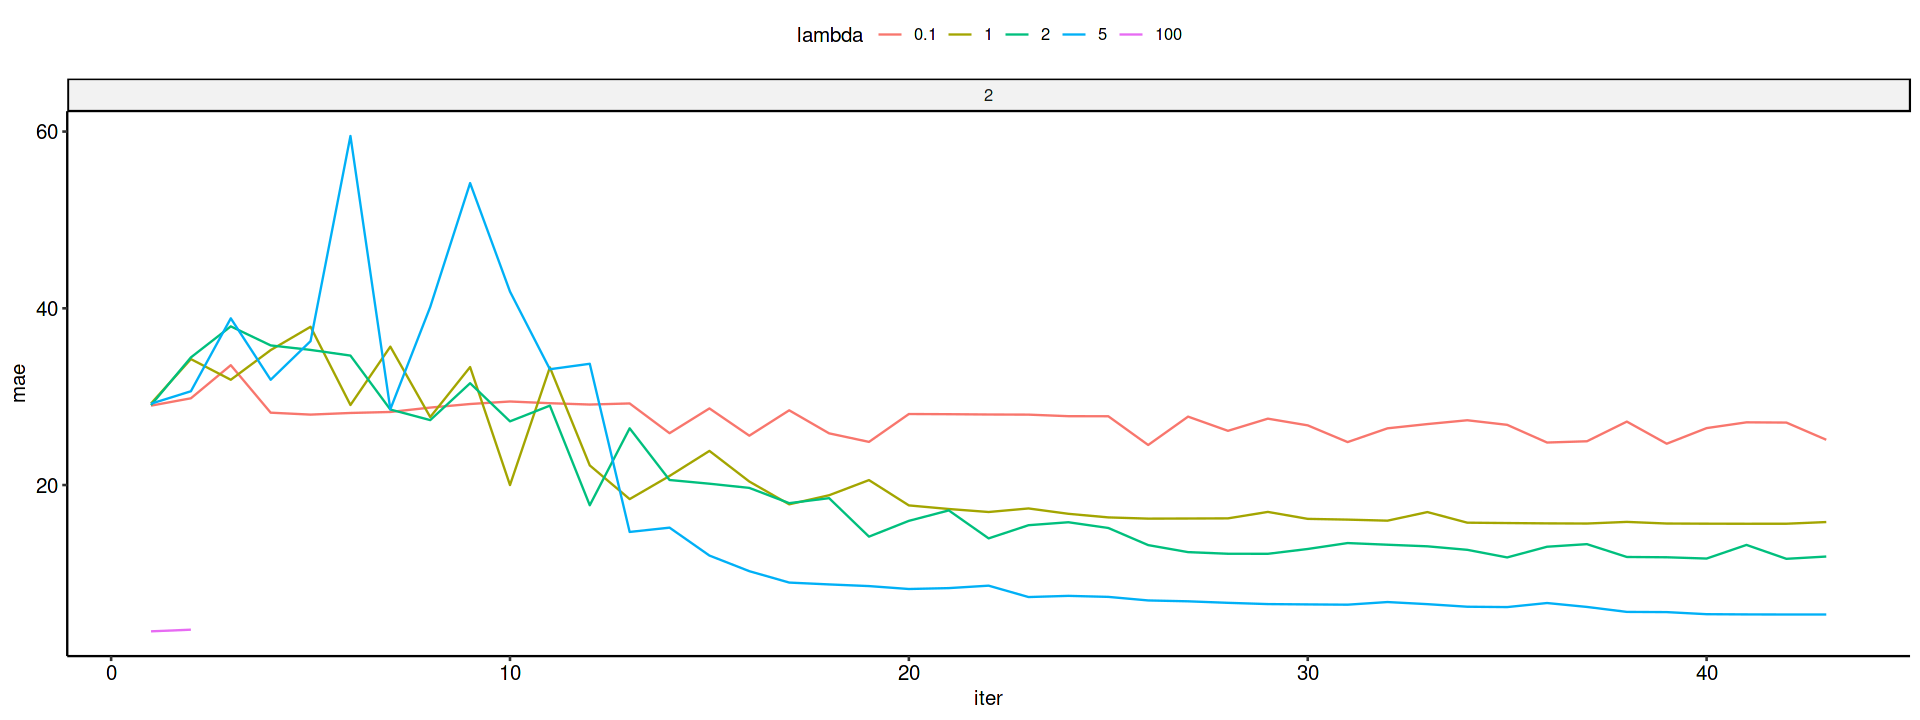

In [383]:
options(repr.plot.width=16, repr.plot.height=6)

p = ggplot(data = performances, aes(x = iter, y = mae, colour = lambda)) + geom_line()
p = p + facet_grid(. ~ dimension)
p

In [384]:
dimension = 2
lambdas = c(0.1, 1, 2, 5, 100)
runs = lapply(lambdas, function(lambda) {
    path = file.path("../data/runs/synthetic", paste0(id, ""), paste0(dimension, "D"))
    readRDS(file.path(path, paste0("mlrmbo_run_lambda_", lambda, "matern32.rds")))
})

In [385]:
names(runs) = paste0("MBO_", lambdas)

In [386]:
opdf = lapply(names(runs), function(name) {
    cbind(as.data.frame(runs[[name]]$opt.path), type = name)
})
opdf = do.call(rbind, opdf)
opdf$type = as.factor(opdf$type)
opdf = setDT(opdf)

In [387]:
types = get_types_of_runs(runs)
names(runs) = types
models = extract_models(runs)
names(models) = types

In [388]:
# ggsave(filename = paste0("performance_traces_", dimension, "D.png"), ggplot(data = performances, aes(x = iter, y = mae, colour = type, group = type)) + geom_line())

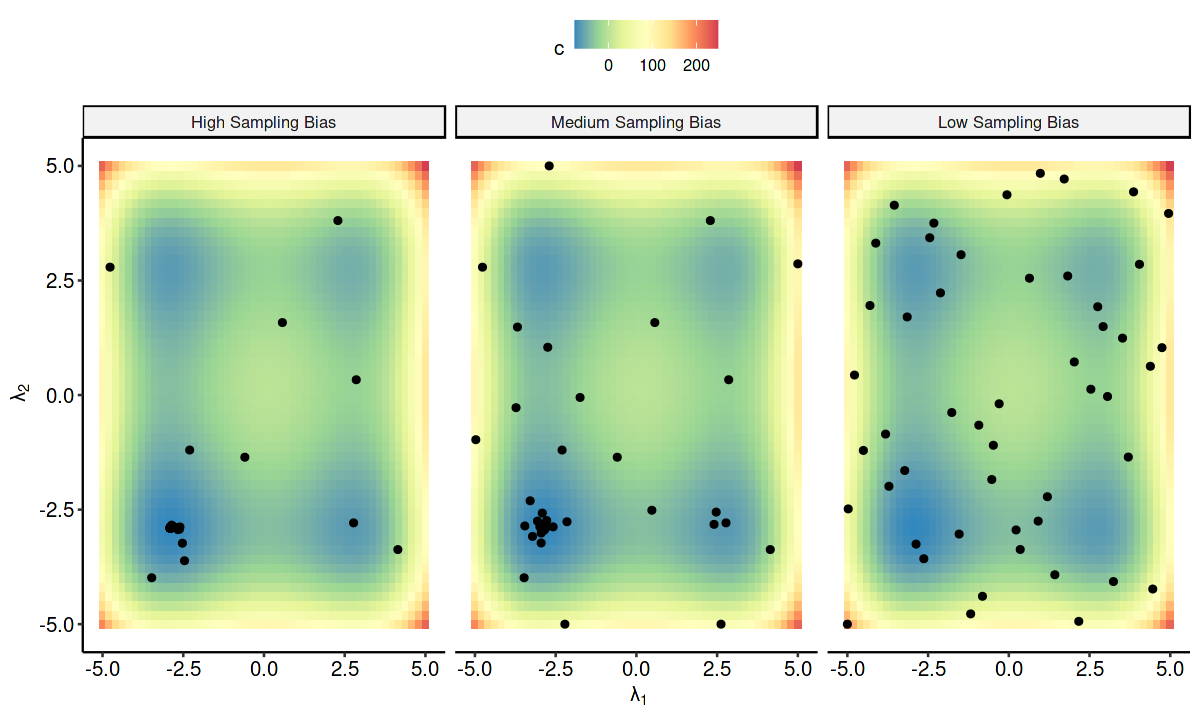

In [478]:
options(repr.plot.width=10, repr.plot.height=6)

opdf_sub = opdf[type %in% c("MBO_0.1", "MBO_2", "MBO_100")]
opdf_sub[type == "MBO_0.1"]$type = "High Sampling Bias"
opdf_sub[type == "MBO_2"]$type = "Medium Sampling Bias"
opdf_sub[type == "MBO_100"]$type = "Low Sampling Bias"

opdf_sub$c = opdf_sub$y
gg$c = gg$y

p1 = ggplot() + geom_tile(data = gg, aes(x = x1, y = x2, fill = c))
p1 = p1 + scale_fill_distiller(palette = "Spectral")
# p = p + geom_point(data = data.frame(x = -2.91, y = -2.91), aes(x = x, y = y), colour = "green", size = 4)
p1 = p1 + geom_point(data = opdf_sub, aes(x = x1, y = x2)) + xlab(~ paste("\u03BB"[1])) + ylab(~ paste("\u03BB"[2]))
p1 = p1 + facet_wrap(. ~ type) 

p1
# ggsave("../results/plots/synthetic/sampling_bias.png", height = 4)

In [481]:
ggsave("sampling_bias.png", p1, width = 7, height = 4)

### Preparation: Investigating the Fit

In [395]:
ps = getParamSet(obj)
gg = generateGridDesign(par.set = ps, resolution = 50L)
gg$y = apply(gg, 1, obj1)

In [396]:
ps

           Type len Def  Constr Req Tunable Trafo
x numericvector   2   - -5 to 5   -    TRUE     -

In [397]:
preds = lapply(names(models), function(idx) {
    pp = predict_on_grid(models[[idx]], gg)
    pp$type = idx
    pp
})
preds = do.call(rbind, preds)

preds$type = as.factor(preds$type)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



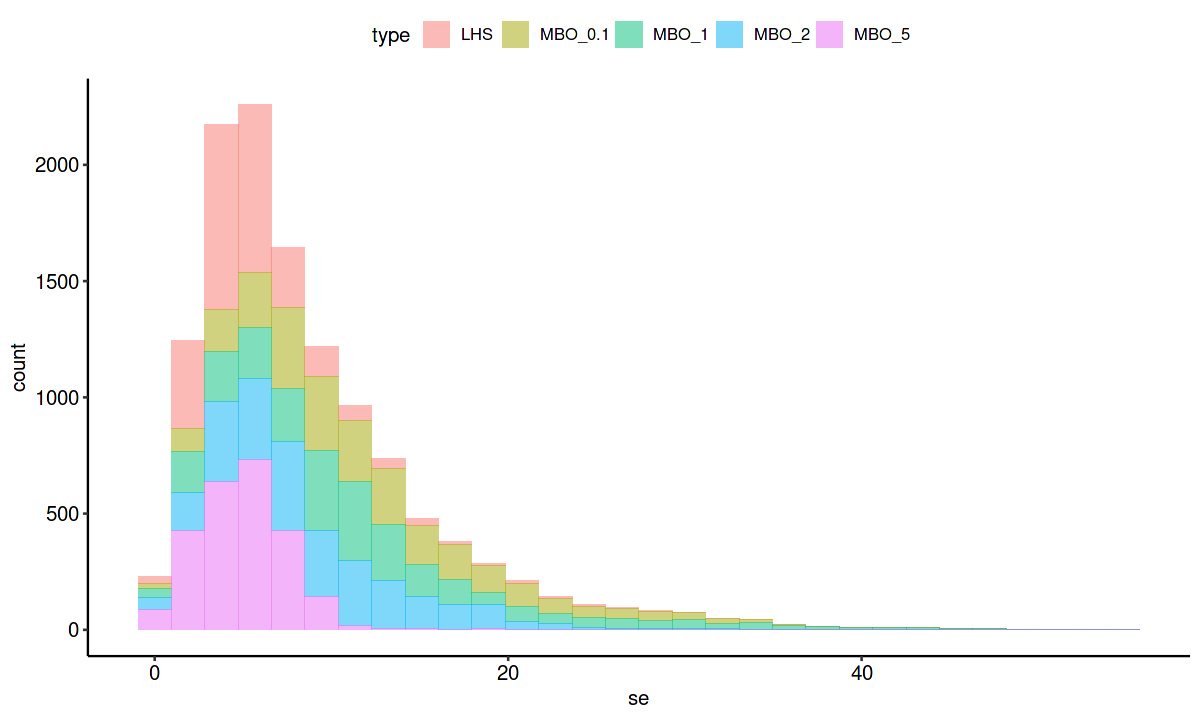

In [398]:
p = ggplot(data = preds, aes(x = se, fill = type)) + geom_histogram(alpha = 0.5)
p

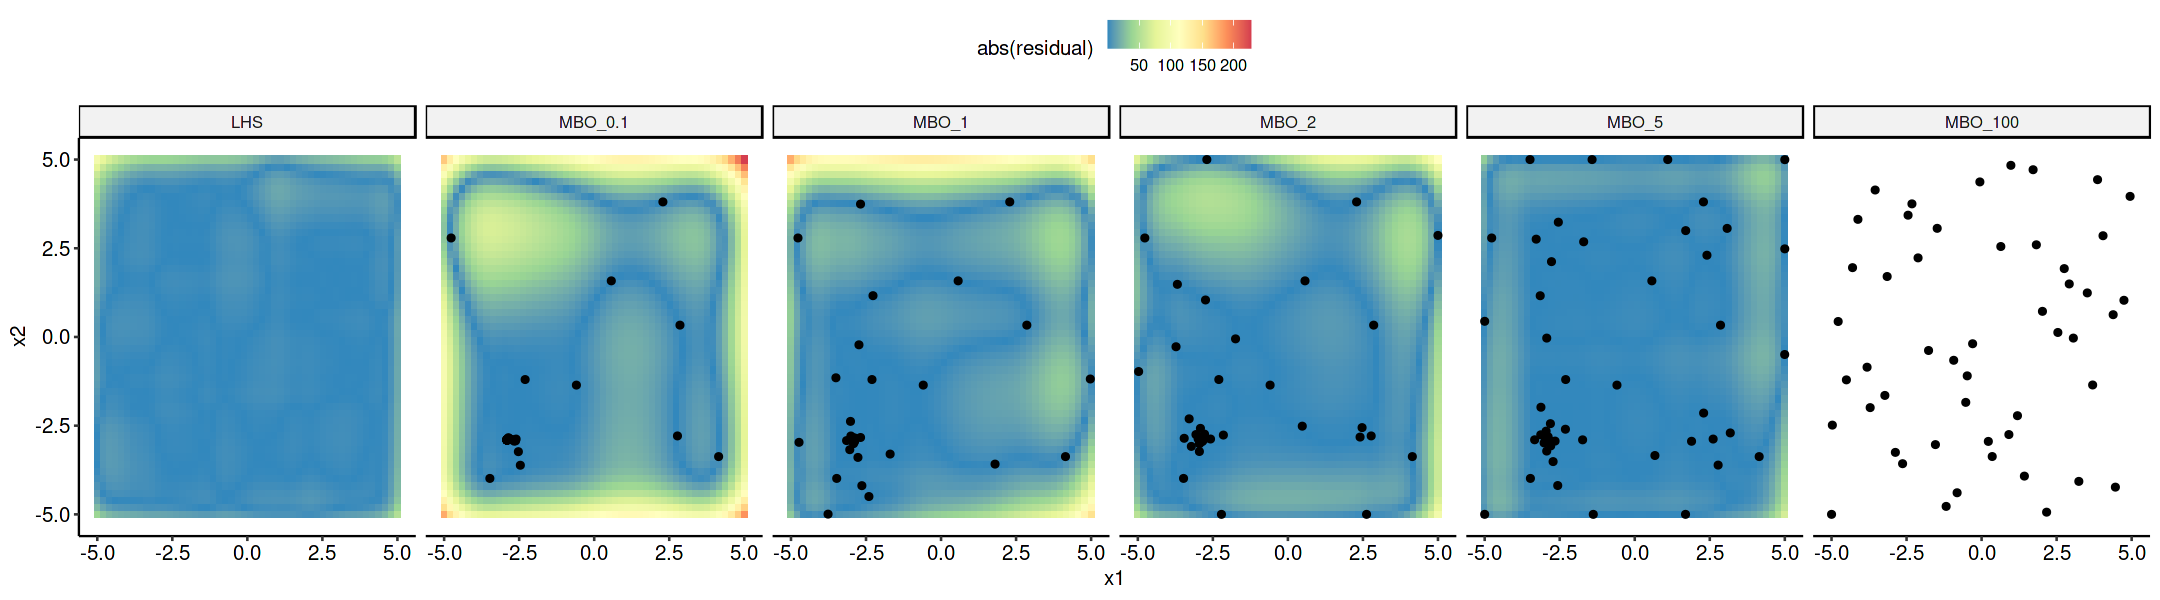

In [399]:
options(repr.plot.width=18, repr.plot.height=5)

p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = abs(residual)))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ type)

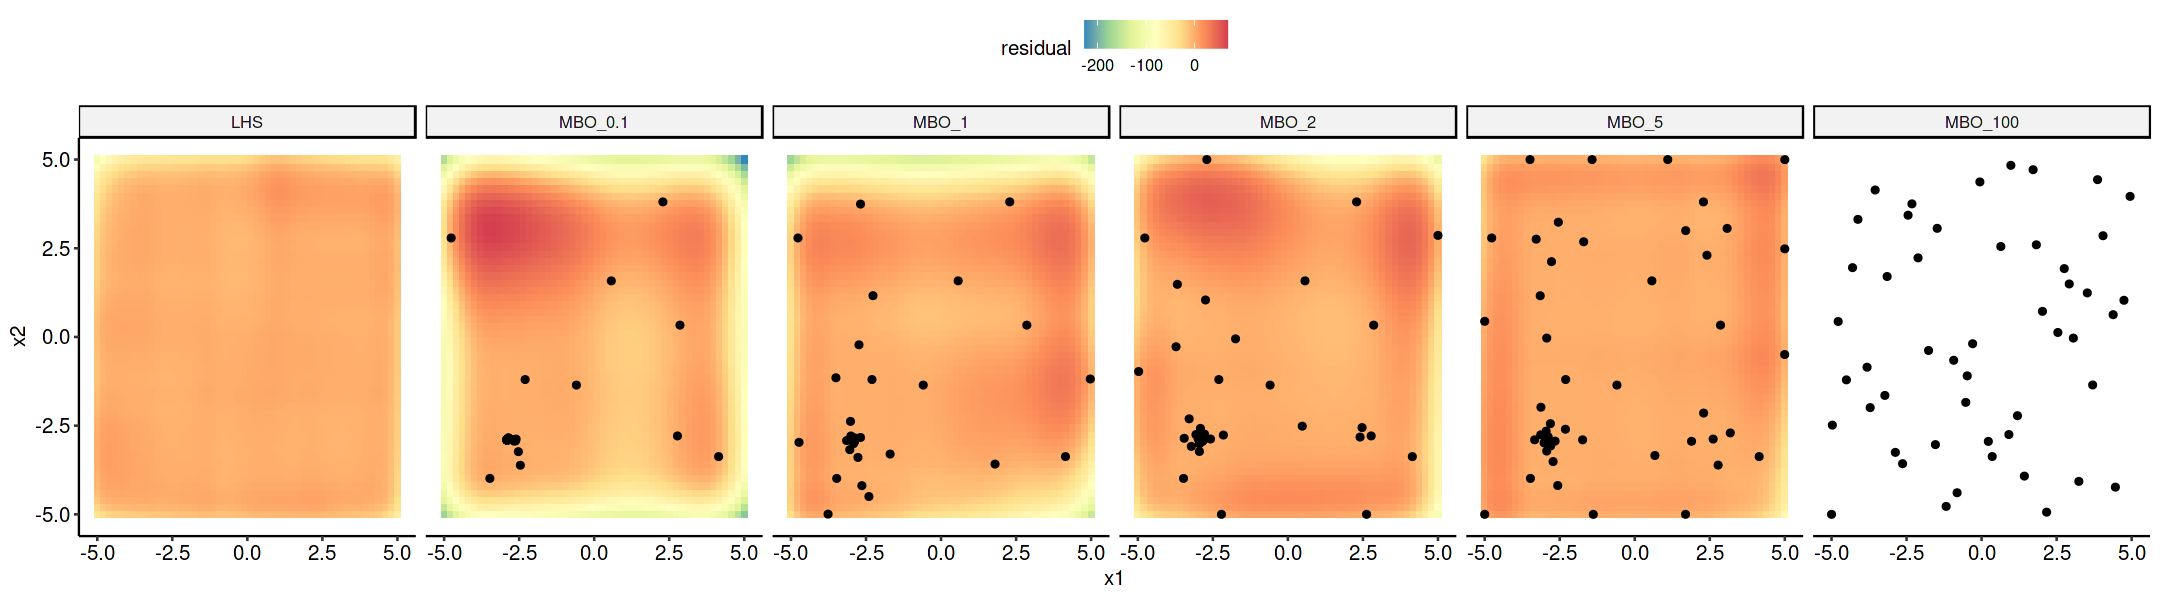

In [400]:
options(repr.plot.width=18, repr.plot.height=5)

p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = residual))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ type)

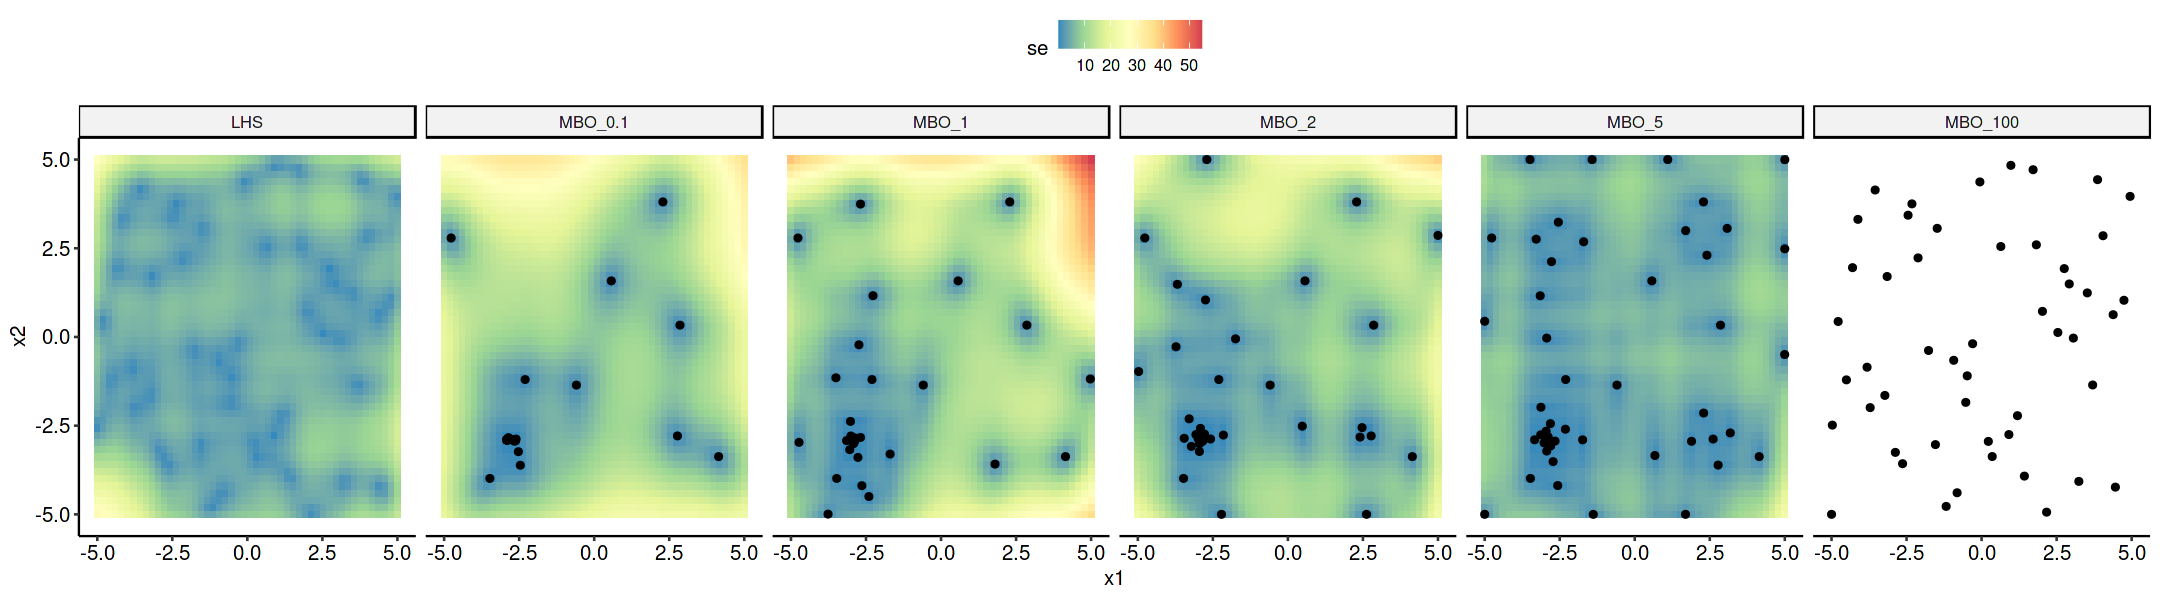

In [401]:
options(repr.plot.width=18, repr.plot.height=5)

p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = se))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ type)

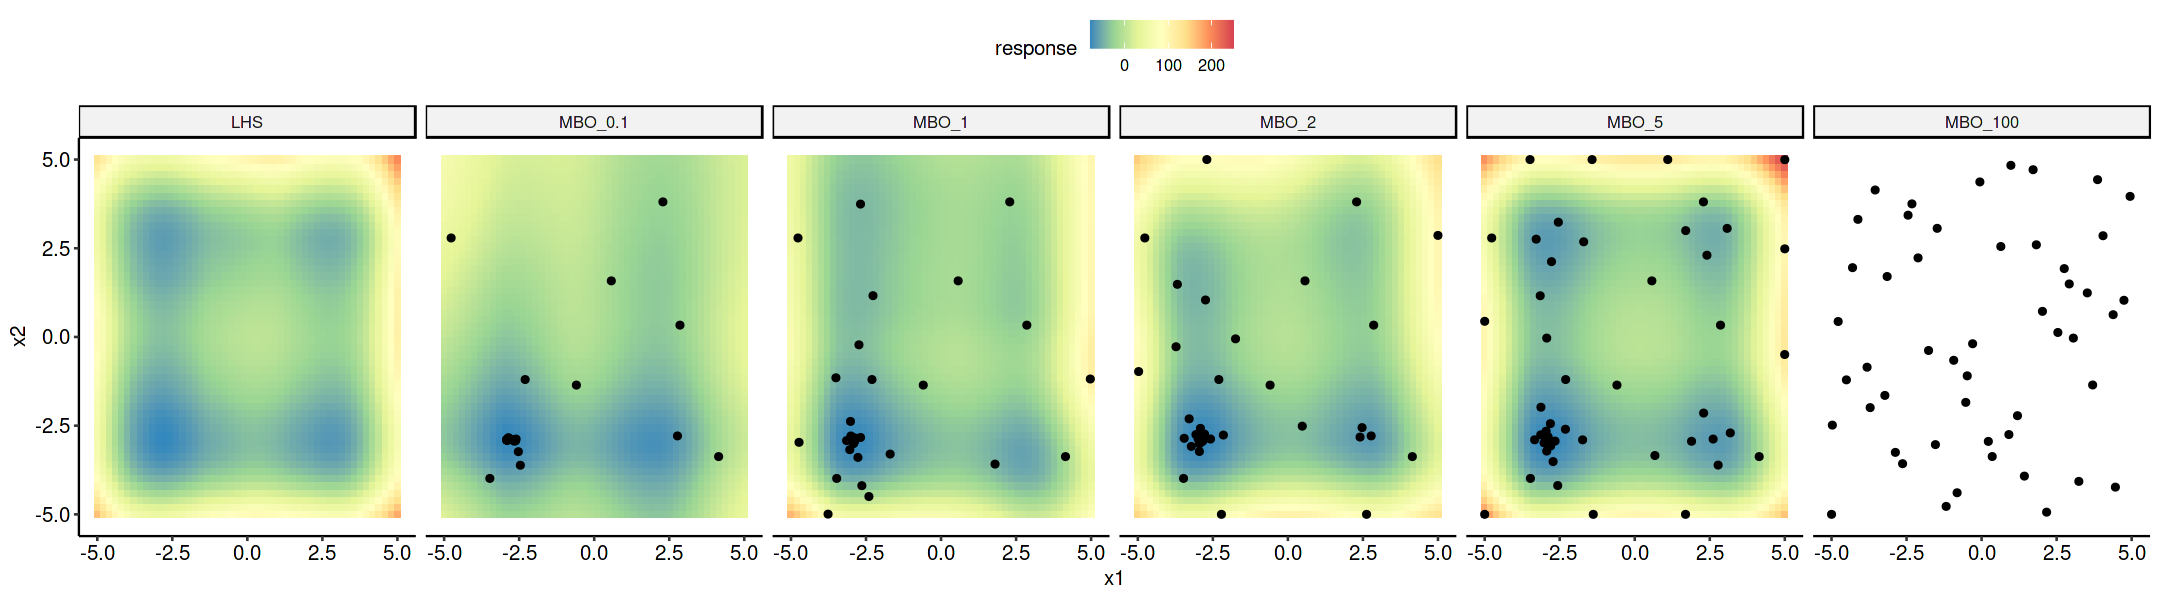

In [402]:
p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = response))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ type)

# High error means over-estimation 

## Maximum Mean Discrepancy

In [412]:
mmd2_estimates = lapply(runs, function(run) {
    df1 = as.data.frame(run$opt.path)[, run$models[[1]]$features]
    df2 = as.data.frame(generateRandomDesign(n = nrow(df1), ps))
    sqrt(mmd2(df1, df2))
})
mmd2_estimates

$MBO_0.1
[1] 0.5979421

$MBO_1
[1] 0.4853843

$MBO_2
[1] 0.3791989

$MBO_5
[1] 0.1994875

$LHS
[1] 0.08507161

### Question 1: Computing the PDP on Training or Test Data? 

A partial dependence plot tries to approximate the following: 

\begin{align*}
\hat f(x_S) & = \mathbb{E}_{x_C}[\hat f(x_S, x_C)] = \int \hat f(x_S, x_C) d\mathbb{P}(x_C)
\end{align*}

The mathematical correct variants of the ground-truth for $\hat f = f$ look like this: 

* Data situation 1: Ground-truth objective and $\mathbb{P}$ is the uniform distribution (ideal world)

\begin{align*}
\hat f_1(x_1) & = (-25 + 15 x_1 - 48 x_1^2 + 3 x_1^4) / 6 \\
\hat f_2(x_1) & = 8 x_1^2 - 80 cos(2 \pi x_1) + 632/3
\end{align*}

* Data situation 2: Ground-truth objective and $\mathbb{P}$ is the distribution from a perfect optimizer which immediately detects the optimum at $x^* = (-2.903.., - 2.903)$.

\begin{align*}
\hat f(x_1) & = 0.5 (x_1^4 - 16 x_1^2 + 5 x_1 - 78.3323) \\
\hat f_2(x_1) &= 20 + x_1^2 - 10 \cos(2 \pi x_1) - 10
\end{align*}

If we fit a PDP on the MBO data we usually approximate something in between. 

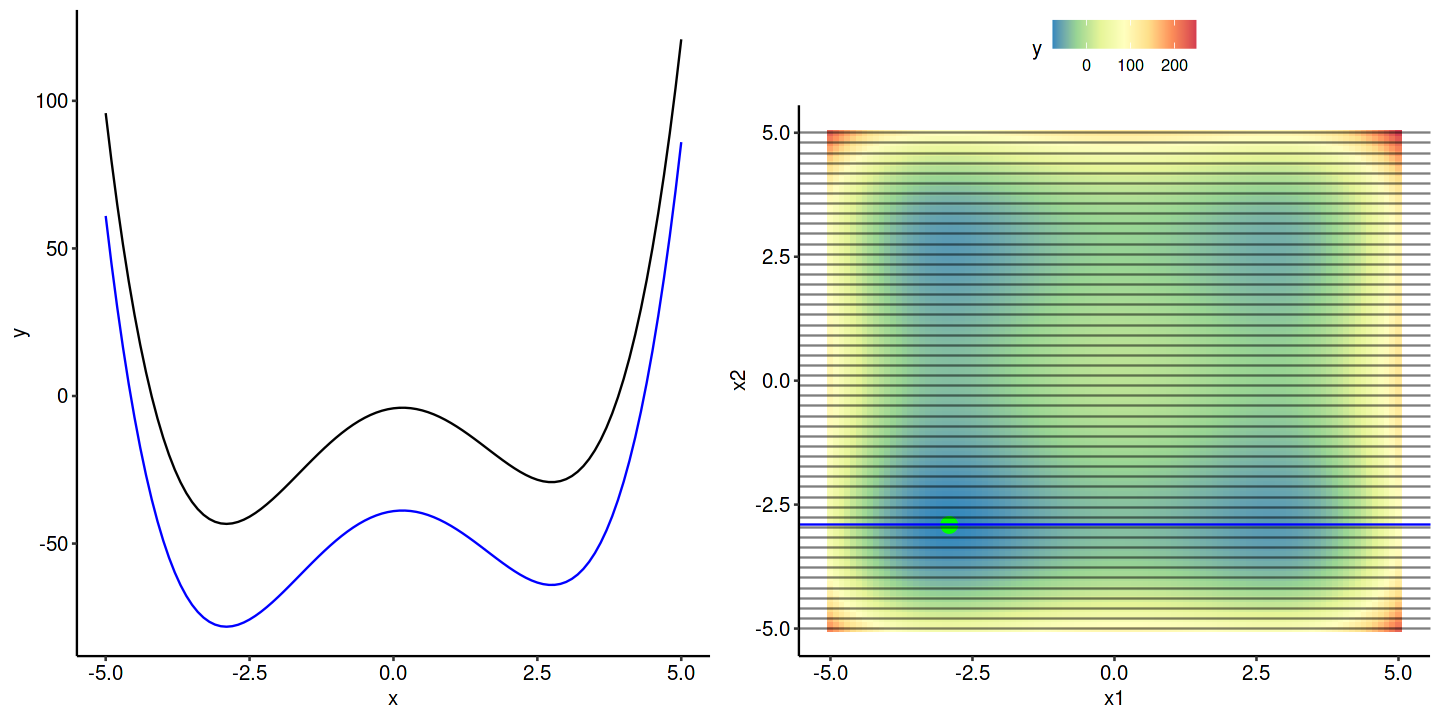

In [328]:
p1 = ggplot() + stat_function(data = data.frame(x = c(-5, 5)), aes(x = x), fun = function(x) 1 / 6 * (3 * x^4 - 48 * x^2 + 15 * x - 25))
lines = seq(-5, 5, length.out = 50)
p1 = p1 + stat_function(data = data.frame(x = c(-5, 5)), aes(x = x), fun = function(x) 1 / 2 * (x^4 - 16 * x^2 + 5 * x - 78), colour = "blue")
p2 = p_obj_1 + geom_hline(data = data.frame(yintercept = lines), aes(yintercept = yintercept), alpha = 0.5)
p2 = p2 + geom_hline(aes(yintercept = -2.903), colour = "blue")

options(repr.plot.width=12, repr.plot.height=6)

grid.arrange(p1, p2, ncol = 2)

In case 1 we are interested in the average feature effect of $x_1$ on $y$.

In case 2 we are interested in the feature effect of $x_1$ on $y$ given $x_2 = x_2^*$.

Usually, what we approximate is something in between but we converge to scenario 2. 

### Question 2: What is the Sampling Bias? 

We compare the partial dependence plots against the ground-truth PDP. 

In [413]:
data = generateRandomDesign(1000, getParamSet(obj))

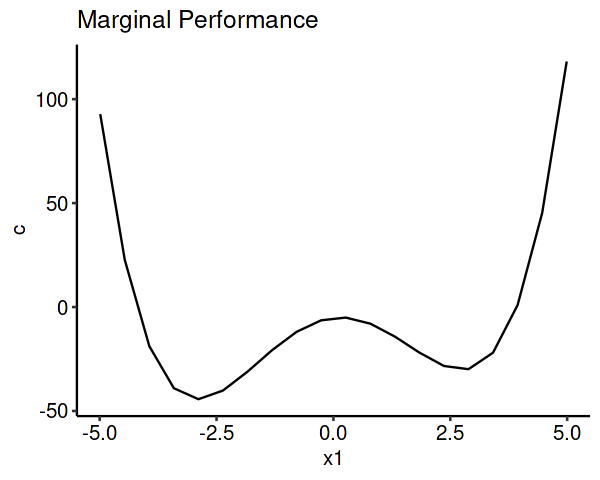

In [414]:
options(repr.plot.width=5, repr.plot.height=4)

marginal_gt = marginal_effect(obj = obj, feature = "x1", data = data, model = models[[1]], grid.size = 20, all.features = models[[1]]$features)

(p = ggplot(data = setDT(marginal_gt)[.type == "pdp", ], aes(x = x1, y = mean)) + geom_line() + ggtitle("Marginal Performance") + ylab(c("c")))

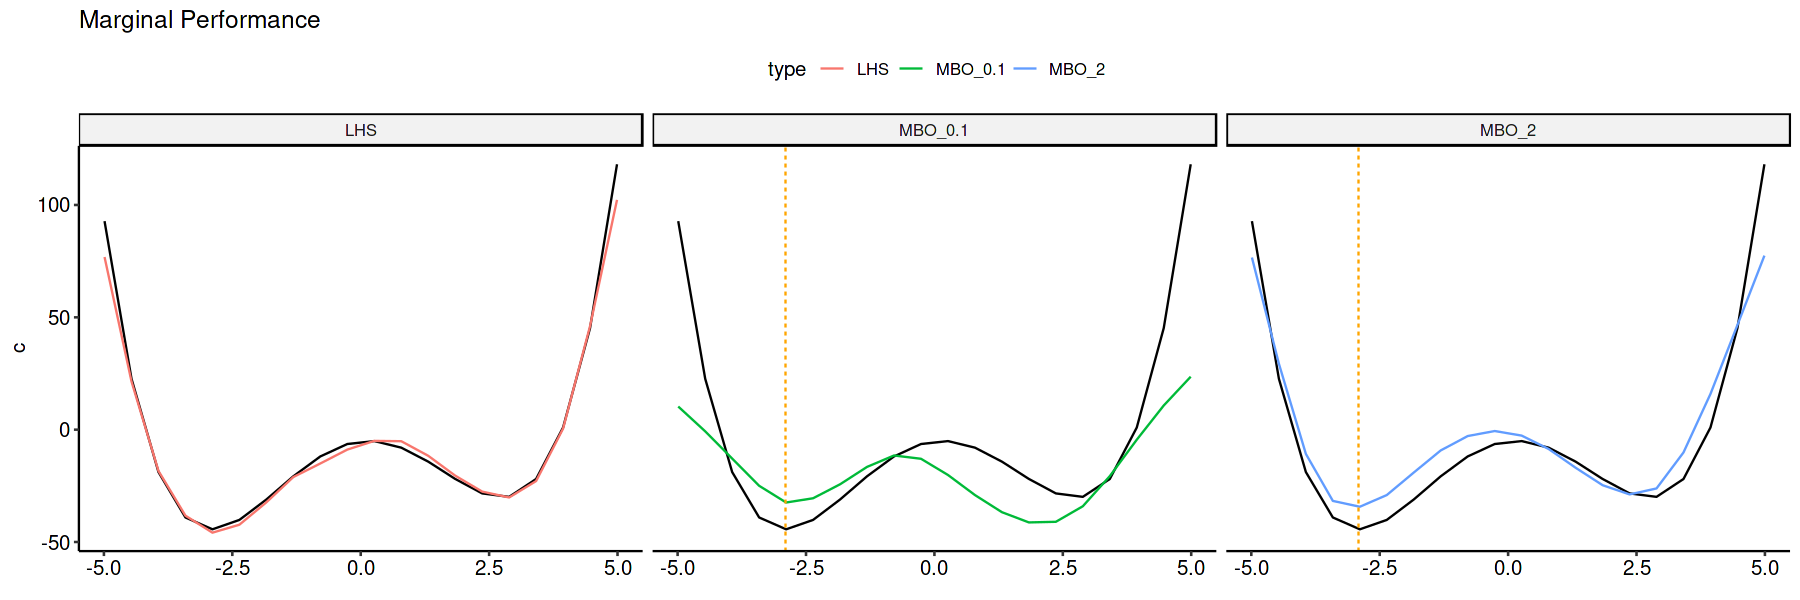

In [439]:
options(repr.plot.width=15, repr.plot.height=5)

feature = "x1"

marginal_pd = lapply(names(models), function(m) {
    pp = marginal_effect_sd_over_mean(models[[m]], feature, data, grid.size = 20, method = "pdp_var")
    # pp = predicted_marginal_effect(models[[m]], "x1", as.data.frame(runs[[m]]$opt.path))
    pp$type = m
    pp
})

mins = opdf[, .SD[which.min(y)], by = type]

marginal_pd = do.call(rbind, marginal_pd)
marginal_pd$type = factor(marginal_pd$type)#, levels = c("MBO_5","MBO_2", "MBO_1", "MBO_0.1"), labels = c("MBO_5","MBO_2", "MBO_1", "MBO_0.1")) 
marginal_pd = as.data.table(marginal_pd)

pl = p + geom_line(data = marginal_pd[type %in% c("LHS", "MBO_0.1", "MBO_2"), ], aes_string(x = feature, y = "mean", colour = "type"))                        
pl = pl + geom_vline(data = mins[type %in% c("LHS", "MBO_0.1", "MBO_2"), ], aes_string(xintercept = "x1"), colour = "orange", lty = 2)
pl + facet_grid(. ~ type)  

In [484]:
marginal_pd_sub = marginal_pd[type %in% c("MBO_0.1", "MBO_2", "LHS")]
marginal_pd_sub[type == "MBO_0.1"]$type = "High Sampling Bias"
marginal_pd_sub[type == "MBO_2"]$type = "Medium Sampling Bias"
marginal_pd_sub[type == "LHS"]$type = "Low Sampling Bias"


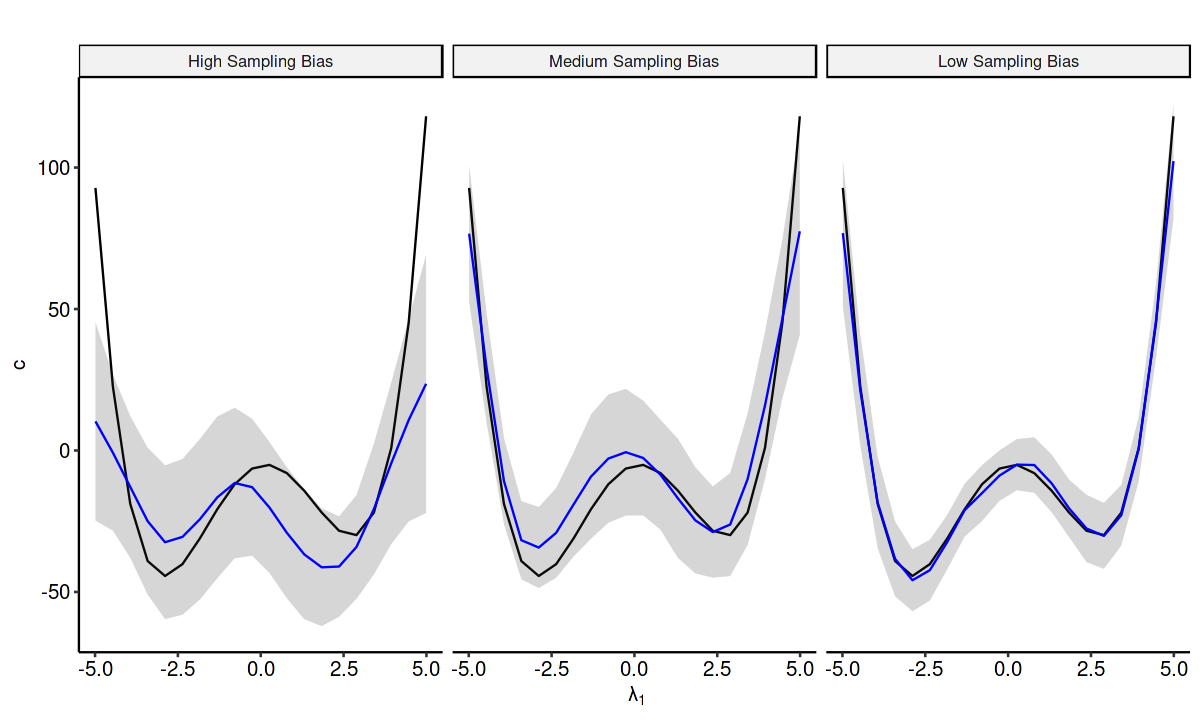

In [489]:
p = p + xlab(expression(lambda))
p1 = p + geom_ribbon(data = marginal_pd_sub, aes(x = x1, ymin = mean - 2 * sd, ymax = mean + 2 * sd), alpha = 0.2) 
p1 = p1 + geom_line(data = marginal_pd_sub, aes(x = x1, y = mean), colour = "blue")
p1 = p1 + xlab(~ paste("\u03BB"[1])) + facet_wrap(. ~ type ) + ggtitle("")
p1

In [493]:
ggsave("pdp_comparison.png", p1, width = 6, height = 3.5)

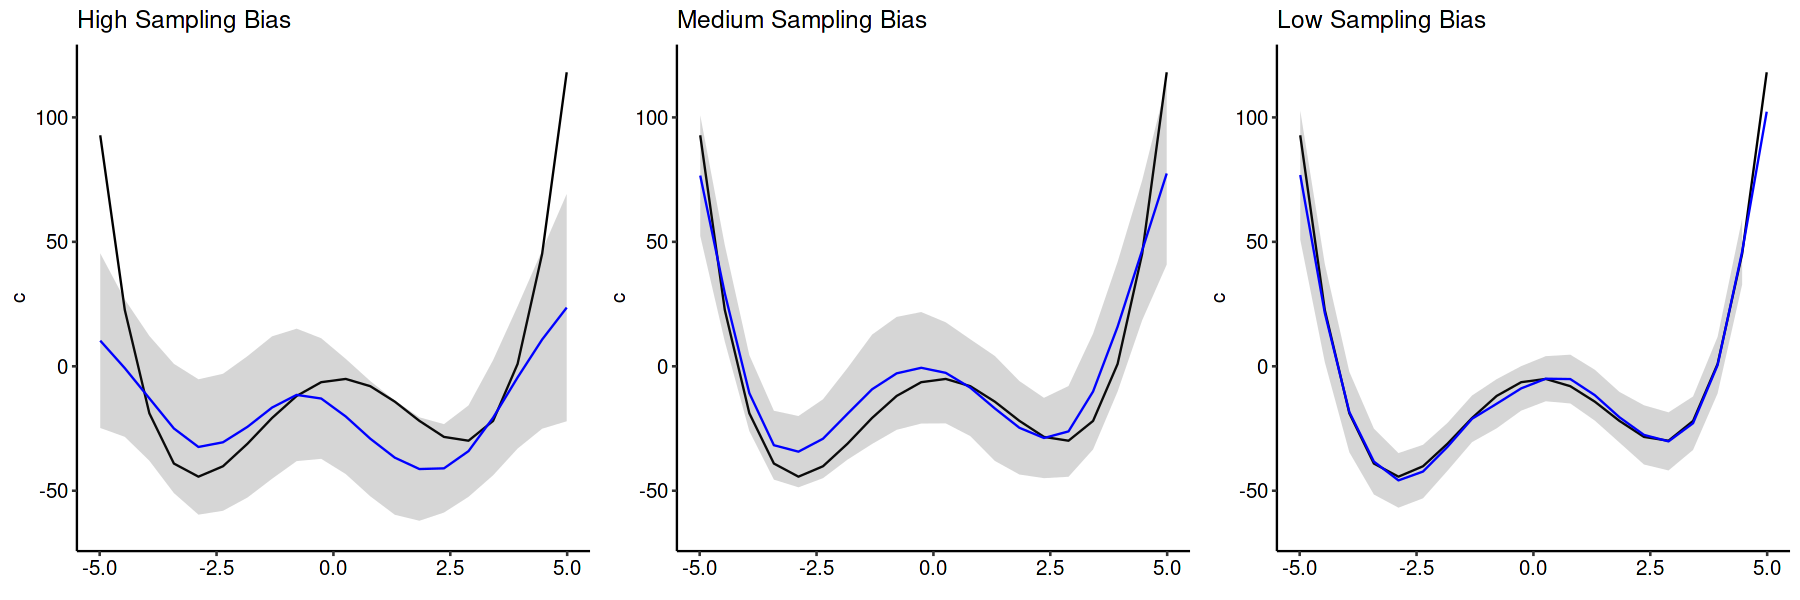

In [451]:
grid.arrange(p1, p2,p3,  nrow = 1)

In [149]:
# Capturing the bias in numbers 

# Compute the absolute deviation

res = lapply(names(models), function(m) {
    mm = marginal_pd[type == m, ]
    mm = merge(mm, marginal_gt, by = "x1")
    mm$dev_abs = mm$mean.x - mm$mean.y
    c(mean(abs(mm$dev_abs)), sd(mm$dev_abs)) 
})

res = do.call(rbind, res)
rownames(res) = names(models)
colnames(res) = c("Mean Abs. Difference", "SD Abs. Difference")
res

,Mean Abs. Difference,SD Abs. Difference
MBO_0.1,30.41479,40.42108
MBO_1,23.38789,32.72849
MBO_2,26.25527,32.97278
MBO_5,NaN,NA
MBO_10,23.72291,31.35400
MBO_100,NaN,NA


### Question 3: How Can We Capture this Effect? 

We use the uncertainty to capture this effect. 

#### Variant 1 (Partial Dependence Plot over the Posterior Variance)

$$
    \hat s(\lambda_S) = \sqrt{\frac{1}{n^2} \sum_{i = 1}^n \hat s^2(\lambda^{(i)})} = \frac{1}{n} \sqrt{ \sum_{i = 1}^n \hat s^2(\lambda^{(i)})}
$$

with $\lambda^{(i)} \sim \textrm{Unif}(X(\lambda_S))$

#### Variant 2 (Partial Dependence Plot over Standard Deviation)

At least in my opinion, this is not mathematically valid...?

$$
    \hat s(\lambda_S) = \frac{1}{n}  \sum_{i = 1}^n \hat s(\lambda^{(i)})
$$

with $\lambda^{(i)} \sim \textrm{Unif}(X(\lambda_S))$

#### Variant 3 (Partial Dependence Taking into Account GP Covariance)

$$
    \hat s(\lambda_S) = \frac{1}{n} \sqrt{\sum_{i,j} K^{(post)}_{i,j}}
$$

In [120]:
models

$MBO_0.1
Model for learner.id=regr.km; learner.class=regr.km
Trained on: task.id = data; obs = 70; features = 3
Hyperparameters: jitter=FALSE,covtype=matern3_2,optim.method=gen,nugget.stability=1e-08

$MBO_1
Model for learner.id=regr.km; learner.class=regr.km
Trained on: task.id = data; obs = 70; features = 3
Hyperparameters: jitter=FALSE,covtype=matern3_2,optim.method=gen,nugget.stability=1e-08

$MBO_2
Model for learner.id=regr.km; learner.class=regr.km
Trained on: task.id = data; obs = 70; features = 3
Hyperparameters: jitter=FALSE,covtype=matern3_2,optim.method=gen,nugget.stability=1e-08

$MBO_10
Model for learner.id=regr.km; learner.class=regr.km
Trained on: task.id = data; obs = 70; features = 3
Hyperparameters: jitter=FALSE,covtype=matern3_2,optim.method=gen,nugget.stability=1e-08


In [127]:
results = list()

for (method in c("pdp_var_gp")) {
    res = lapply(names(models), function(m) {
        pp = marginal_effect_sd_over_mean(model = models[[m]], feature = "x1", data = data, method = method, grid.size = 20)
        # pp = marginal_effect_sd_over_mean(models[[m]], "x1", as.data.frame(runs[[m]]$opt.path), method = method)
        pp$type = m
        pp
    })
    res = do.call(rbind, res)
    res$method = method
    results[[method]] = res
}

In [128]:
results = do.call(rbind, results)

In [138]:
alpha = 0.01

In [139]:
results$upper = unlist(lapply(seq_row(results), function(i) {
    qnorm(p = 1 - alpha / 2, mean = results[i, ]$mean, sd = results[i, ]$sd)
}))

results$lower = unlist(lapply(seq_row(results), function(i) {
    qnorm(p = alpha / 2, mean = results[i, ]$mean, sd = results[i, ]$sd)
}))

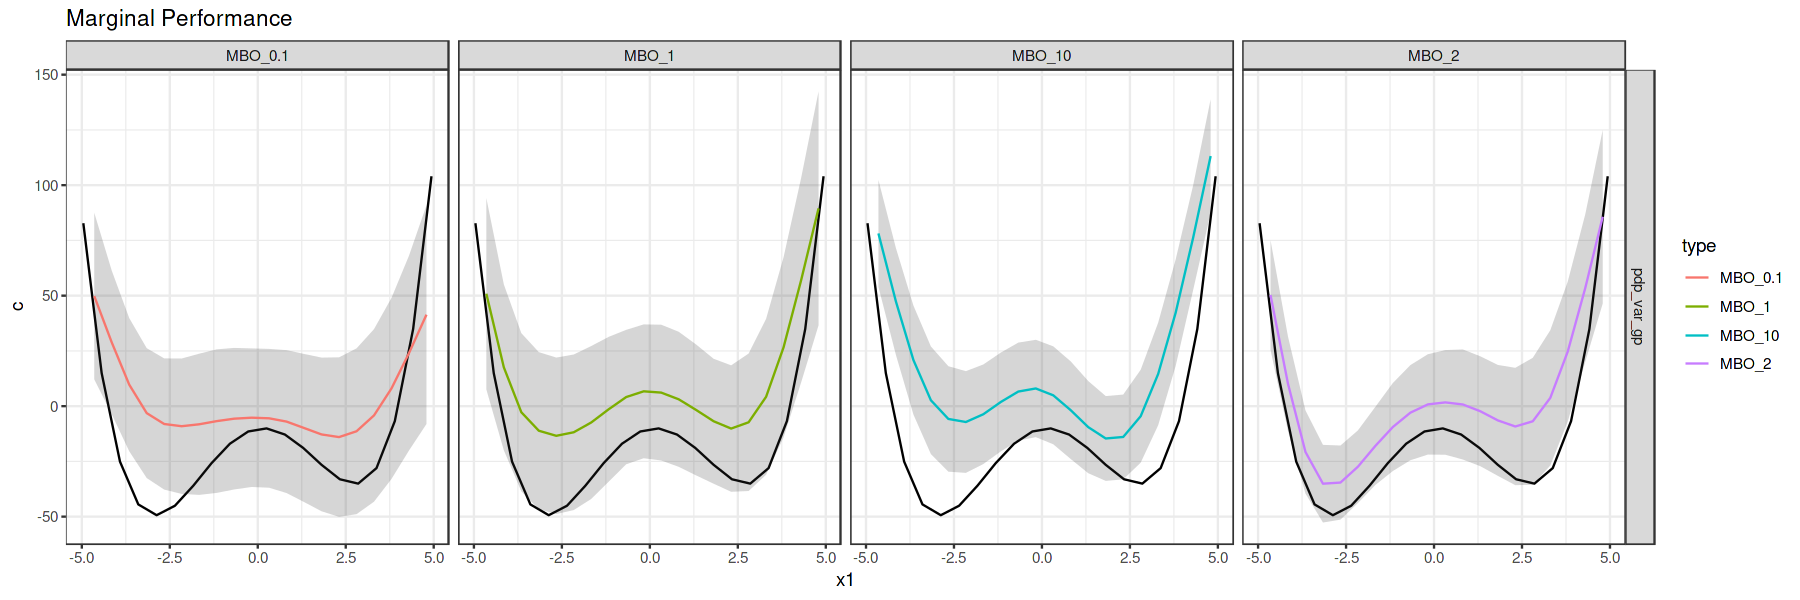

In [140]:
options(repr.plot.width=15, repr.plot.height=5)

q = qnorm(1 - alpha / 2)

pl = p + geom_ribbon(data = results[method %in% c("pdp_var_gp"), ], aes(x = x1, ymin = mean - q * sd, ymax = mean + q * sd), alpha = 0.2)
pl = pl + geom_line(data = results[method %in% c("pdp_var_gp"), ], aes(x = x1, y = mean, colour = type)) + facet_grid(method ~ type)
pl

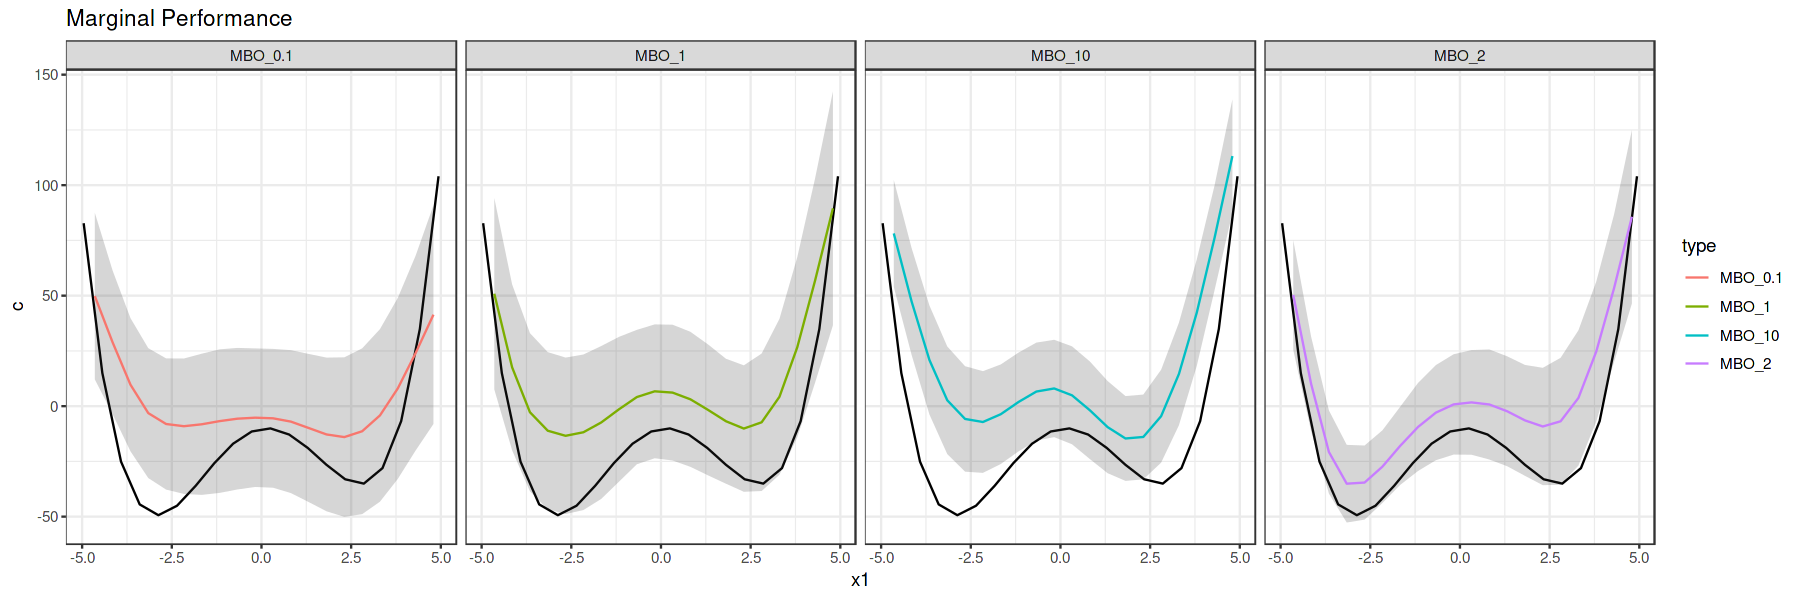

In [141]:
options(repr.plot.width=15, repr.plot.height=5)

pl = p + geom_ribbon(data = results[method %in% c("pdp_var_gp"), ], aes(x = x1, ymin = lower, ymax = upper), alpha = 0.2)
pl = pl + geom_line(data = results[method %in% c("pdp_var_gp"), ], aes(x = x1, y = mean, colour = type)) + facet_grid(. ~ type)
pl

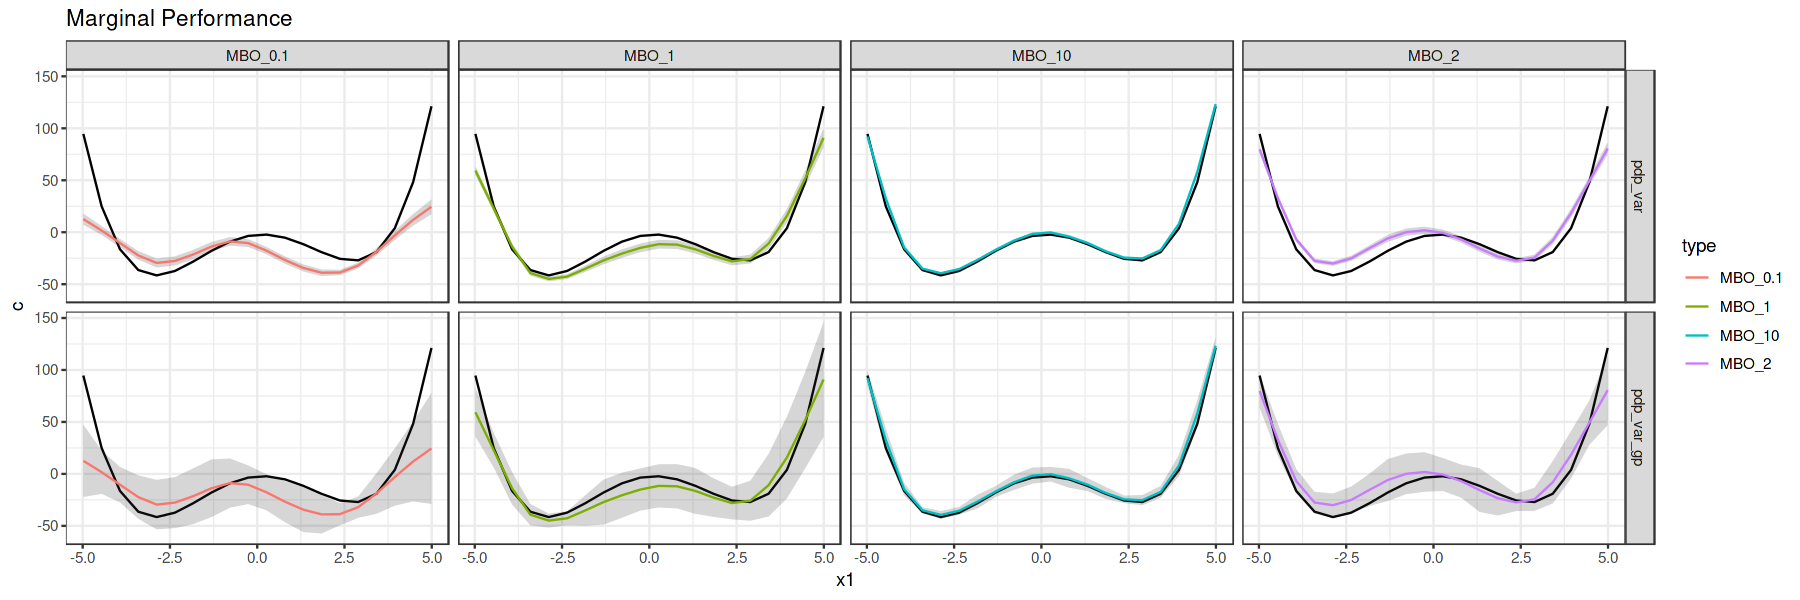

In [27]:
# with Bonferroni correction

alpha = 0.05
m = 20

alpha_corr = alpha / m

q = qnorm(1 - alpha_corr / 2)
pl = p + geom_ribbon(data = results[method %in% c("pdp_var"), ], aes(x = x1, ymin = mean - q * sd, ymax = mean + q * sd), alpha = 0.2)
pl = pl + geom_line(data = results[method %in% c("pdp_var"), ], aes(x = x1, y = mean, colour = type)) + facet_grid(method ~ type)
pl2 = pl
pl

In [43]:
# options(repr.plot.width=9, repr.plot.height=9)

# pl = p + geom_ribbon(data = results[method %in% c("pdp_var_gp", "thompson"), ], aes(x = x1, ymin = mean - 2 * sd, ymax = mean + 2 * sd), alpha = 0.2)
# pl = pl + geom_line(data = results[method %in% c("pdp_var_gp", "thompson"), ], aes(x = x1, y = mean, colour = type)) + facet_grid(type ~ method)
# pl

In [44]:
# options(repr.plot.width=9, repr.plot.height=9)

# pl = p + geom_ribbon(data = results[method %in% c("pdp_var_gp", "pdp_var"), ], aes(x = x1, ymin = mean - 2 * sd, ymax = mean + 2 * sd), alpha = 0.2)
# pl = pl + geom_line(data = results[method %in% c("pdp_var_gp", "pdp_var"), ], aes(x = x1, y = mean, colour = type)) + facet_grid(type ~ method)
# pl

In [45]:
# Alternative Approach 
# results2 = list()

# for (method in c("pdp_cond", "pdp_cond_thomps")) {
#     res = lapply(names(models), function(m) {
#         pp = conditional_mean_sd(models[[m]], "x1", data, method = method)
#         pp$type = m
#         pp
#     })
#     res = do.call(rbind, res)gginnards
#     res$method = method
#     results2[[method]] = res
# }

In [40]:
# results2 = do.call(rbind, results2)

In [46]:
# options(repr.plot.width=8, repr.plot.height=12)

# pl = p + geom_ribbon(data = results2, aes(x = x1, ymin = mean - 2 * sd, ymax = mean + 2 * sd), alpha = 0.2)
# pl = pl + geom_line(data = results2, aes(x = x1, y = mean, colour = type)) + facet_grid(type ~ method)
# pl

In [ ]:
model = models[[1]]

predictor = Predictor$new(model, data = data)

effects = FeatureEffect$new(predictor = predictor, feature = feature, grid.size = 2, method = "ice")

# Extract the learned GP 
km = model$learner.model

# Covtype is needed later to extract the covariance 
covtype = attr(km, "covariance")

# Compute the covariance matrix and the mean for this whole design 
design = merge(effects$results$x1, predictor$data$X$x2)
names(design) = c("x1", "x2")

# Predict on this big design 
pred = predict(object = km, newdata = design, type = "SK", cov.compute = TRUE)
C = pred$cov
m = pred$mean 

dfl = cbind(id = seq_row(design), design, m = m, C = C)

In [81]:
feature = "x1"
gridvalues = me[, feature]

In [82]:
km = models[[1]]$learner.model

In [83]:
res = lapply(gridvalues, function(gv) {

    # Create vector along the gridvalue gv by combining it with the "test dataset"
    gg = merge(gv, data[, setdiff(colnames(data), feature)])
    names(gg) = c(feature, setdiff(colnames(data), feature))
    gg = gg[, names(data)]

    # Compute the posterior mean and covariance of the predictions at points in gg

    return(gg)
})

In [84]:
res = do.call(rbind, res)

In [85]:
pred = predict(object = km, newdata = res, type = "SK", cov.compute = TRUE)
C = pred$cov
m = pred$mean 

## Further Visualization for the Paper

In [612]:
# Plot a PDP with two ICE curves 

lambda = 0.1

model = models[["MBO_0.1"]]
df = opdf[type == "MBO_0.1"]
df$c = df

In [624]:
gg$c = gg$y
p_obj_1 = ggplot() + geom_tile(data = gg, aes(x = x1, y = x2, fill = c))
p_obj_1 = p_obj_1 + scale_fill_distiller(palette = "Spectral")
# p_obj_1 = p_obj_1 + geom_point(data = data.frame(x = -2.91, y = -2.91), aes(x = x, y = y), colour = "green", size = 4)


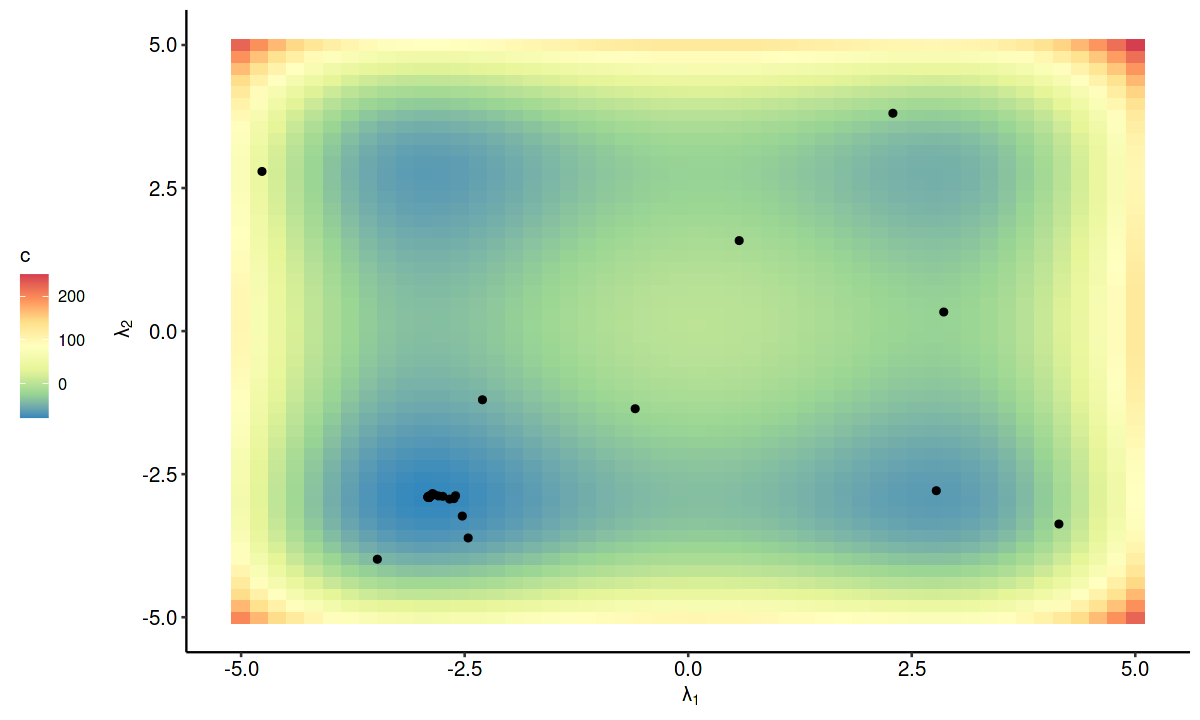

In [627]:
p = p_obj_1 + geom_point(data = df, aes(x = x1, y = x2)) + xlab(~ paste("\u03BB"[1])) + ylab(~ paste("\u03BB"[2]))
p = p + theme(legend.position = "left")
p

In [628]:
# ICE Curve 1 

gridvalues = seq(-5, 5, length.out = 20)

id1 = 2
id2 = 17

ic1 = data.frame(x1 = gridvalues, x2 = df[id1, ]$x2)
ic1$y = apply(ic1, 1, obj)

ic2 = data.frame(x1 = gridvalues, x2 = df[id2, ]$x2)
ic2$y = apply(ic2, 1, obj)
ic2$type = "2"
ic1$type = "1"


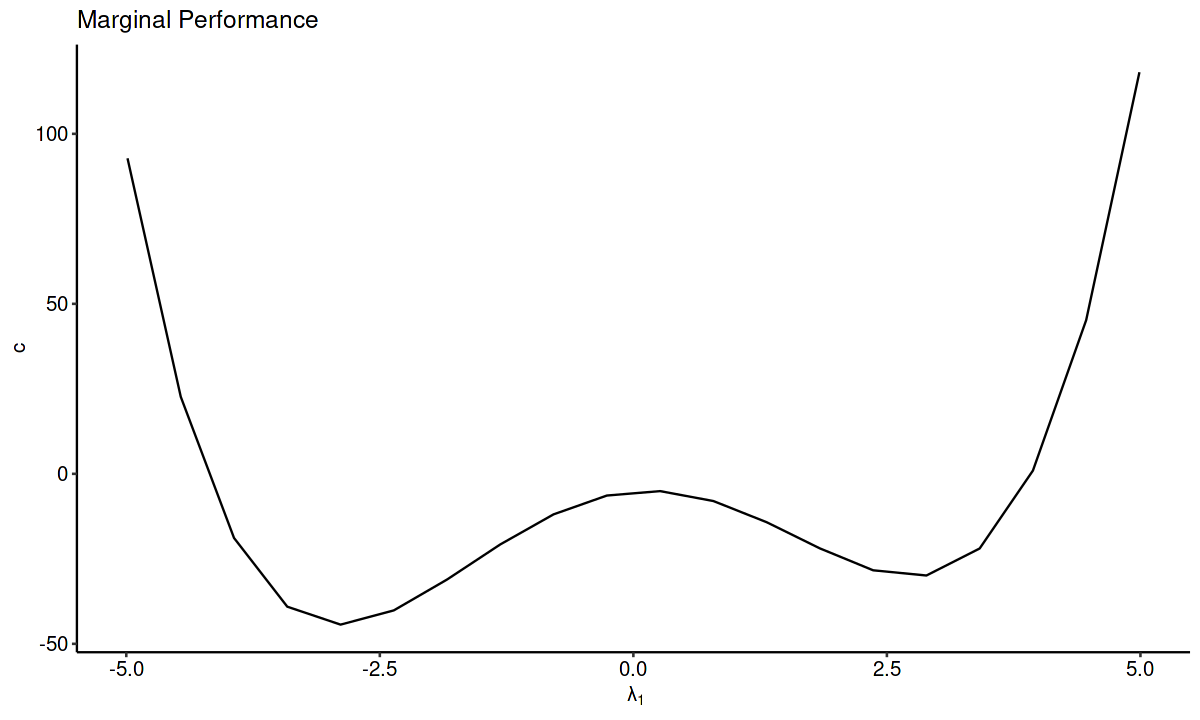

In [629]:
pgt = ggplot(data = setDT(marginal_gt)[.type == "pdp", ], aes(x = x1, y = mean)) + geom_line() + ggtitle("Marginal Performance") + ylab(c("c"))
pgt = pgt + xlab(~ paste("\u03BB"[1])) 
pgt

In [630]:
ic = rbind(ic1, ic2)

In [631]:
ic = cbind(ic, predict(model, newdata = ic[, c("x1", "x2")])$data)

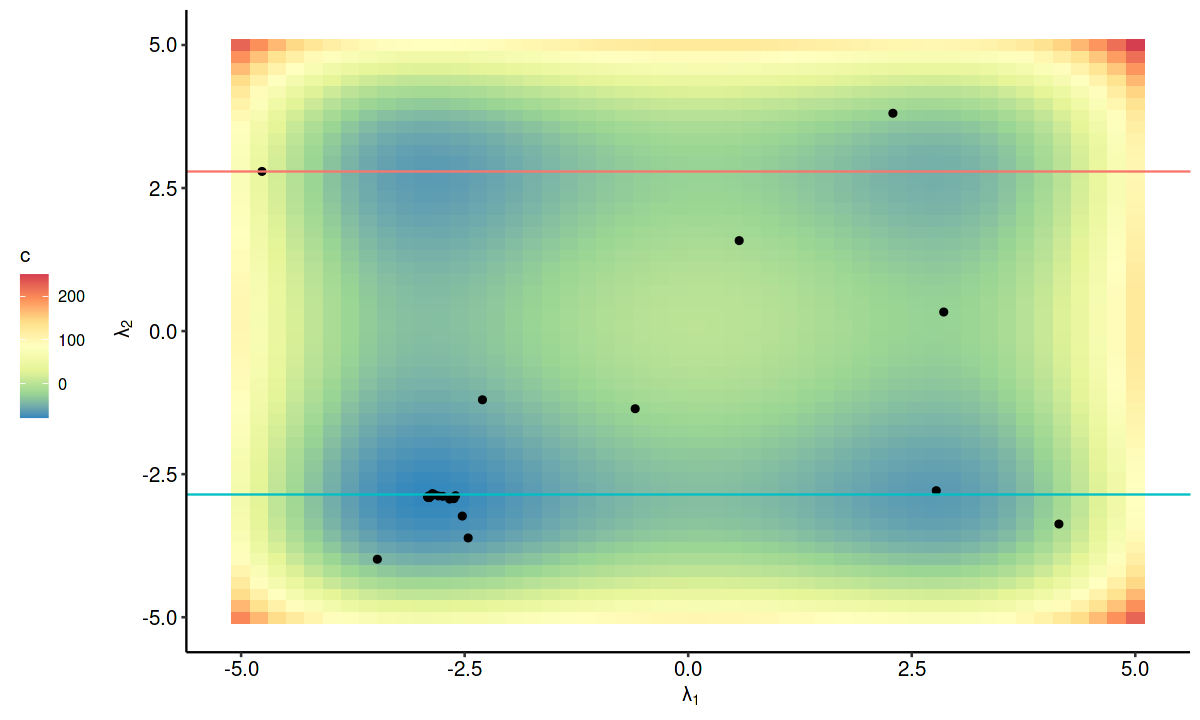

In [637]:
p1 = p + geom_hline(data = ic, aes(yintercept = x2, colour = type), show.legend = FALSE)
p1

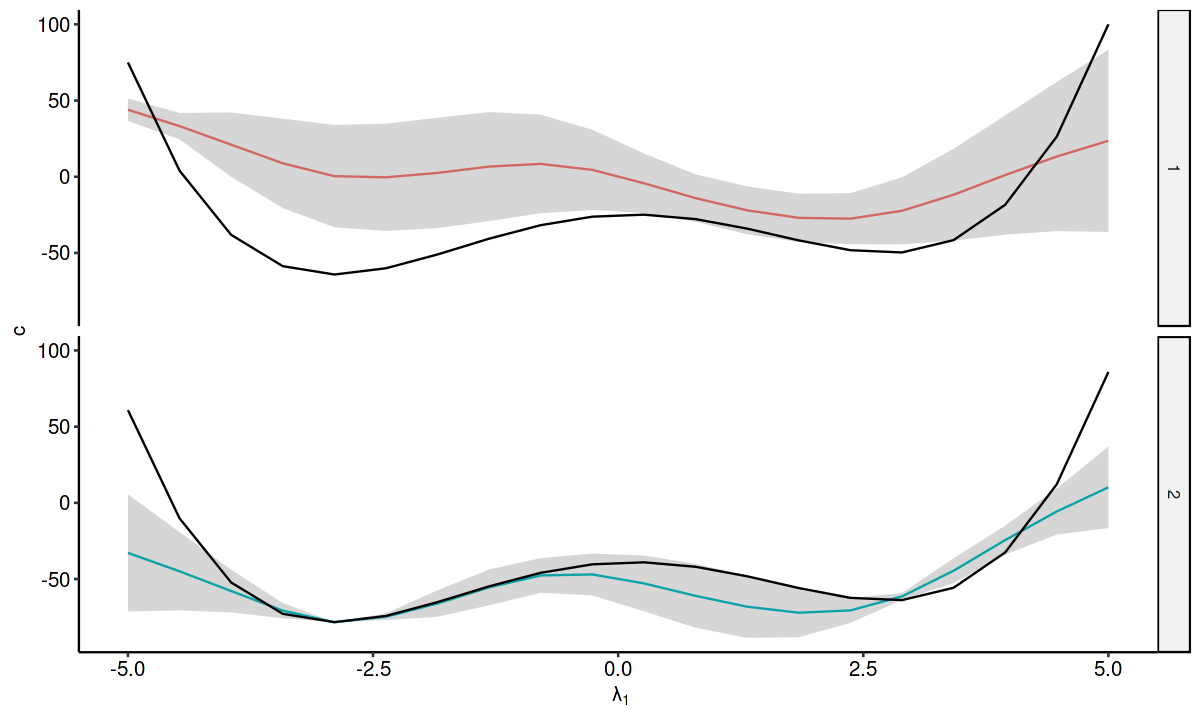

In [638]:
p2 = ggplot() + geom_line(data = ic, aes(x = x1, y = response, colour = type))
p2 = p2 + geom_ribbon(data = ic, aes(x = x1, ymin = response - 2 * se, ymax = response + 2 * se), alpha = 0.2)
p2 = p2 + geom_line(data = ic, aes(x = x1, y = y)) + xlab(~ paste("\u03BB"[1]))  + ylab("c")
p2 = p2 + facet_grid(type ~ .) + theme(legend.position = "none")
p2

In [646]:
ggsave("ice_curves_example.png", ggarrange(p1, p2, nrow = 1, common.legend = TRUE), width = 7, height = 3.5)

In [150]:
plotPDPICE = function(obj, runtype, feature, testdata_runtype, gt = FALSE) {
    opdf_sub = data.frame(opdf[cb.lambda.t == testdata_runtype, ])
    predictor = Predictor$new(models[[runtype]], data = opdf_sub[c("x1", "x2")])
    effects = FeatureEffect$new(predictor = predictor, feature = feature, method = "pdp+ice")
    p = effects$plot() + ggtitle(runtype)
    if (gt) {
        df = gtPDP(feature)
        p = p + geom_line(data = df, aes(x = x, y = y), colour = "blue", lty = 2)
    }    
    return(p)
}

In [151]:
options(repr.plot.width=12, repr.plot.height=6)

p1 = plotPDP(obj1, "lambda1", "x1", "LHS", gt = TRUE, se = TRUE) + ggtitle("MBO-model on test data") 
p2 = plotPDP(obj1, "LHS", "x1", "LHS", gt = TRUE, se = TRUE) + ggtitle("LHS-model on test data") 
grid.arrange(p1, p2, ncol = 2)

ERROR: Error in plotPDP(obj1, "lambda1", "x1", "LHS", gt = TRUE, se = TRUE): could not find function "plotPDP"


In [ ]:
options(repr.plot.width = 8, repr.plot.height = 6)

preds = setDT(preds)

example_ice_curves = data.frame(y = c(2.5, -1), type = c("ice_curve_1", "ice_curve_2"))

# Explanation
p2 = ggplot() + geom_tile(data = preds[cb.lambda.t == "lambda1", ], aes(x = x1, y = x2, fill = se))
p2 = p2 + geom_point(data = opdf[cb.lambda.t == "lambda1", ], aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 = p2 + geom_hline(data = example_ice_curves, aes(yintercept = y, colour = type))

In [ ]:
options(repr.plot.width = 14, repr.plot.height = 6)

x1 = seq(-5, 5, by = 0.01)
df_ice = data.frame(x1 = x1, x2 = example_ice_curves$y[1], type = "ice_curve_1")
df_ice = rbind(df_ice, data.frame(x1 = x1, x2 = example_ice_curves$y[2], type = "ice_curve_2"))
pred = predict(models[["lambda1"]], newdata = df_ice[, c("x1", "x2")])
df_ice$response = pred$data$response
df_ice$se = pred$data$se
df_ice$gt = apply(df_ice[, c("x1", "x2")], 1, obj1)

p1 = ggplot() 
p1 = p1 + geom_line(data = df_ice, aes(x = x1, y = gt, group = type), colour = "blue", lty = 2)
p1 = p1 + geom_line(data = df_ice, aes(x = x1, y = response, colour = type))
p1 = p1 + facet_grid(type ~ .)

grid.arrange(p2, p1, ncol = 2)

In [ ]:
p1 = ggplot()
p1 = p1 + geom_ribbon(data = df_ice, aes(x = x1, ymin = response - 2 * se, ymax = response + 2 * se), fill = "grey70", alpha = 0.5)
p1 = p1 + geom_line(data = df_ice, aes(x = x1, y = gt, group = type), colour = "blue", lty = 2)
p1 = p1 + geom_line(data = df_ice, aes(x = x1, y = response, colour = type))
p1 = p1 + facet_grid(type ~ .)

grid.arrange(p2, p1, ncol = 2)

### Question 4: What Can We Do Against It? 

In [494]:
model_for_interpretation = "MBO_0.1"
model = models[[model_for_interpretation]]
feat = "x1"

In [504]:
ps_ids

[1] "x"

In [507]:
# Testdata 
df = generateDesign(par.set = ps, n = 1000, fun = lhs::randomLHS)

ps_ids = getParamIds(ps, with.nr = TRUE, repeated = TRUE)
mymodel = makeS3Obj("mymodel", fun = function() return(model))
predict.mymodel = function(object, newdata) {
  pred = predict(object$fun(), newdata = newdata)
  pp = getPredictionSE(pred)
  return(pp)
}
predictor = Predictor$new(model = mymodel, data = df[, ps_ids], predict.function = predict.mymodel)
effect = FeatureEffect$new(predictor = predictor, feature = feat, method = "ice")


# Compute tree
tree = compute_tree(effect_sd = effect, testdata =  df, objective = "SS_L1", n.split = 2)

Loading required package: Rfast

Loading required package: Rcpp

Loading required package: RcppZiggurat


Attaching package: ‘Rfast’


The following object is masked from ‘package:data.table’:

    transpose


